<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=70, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=70, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW100Seed_22channels.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


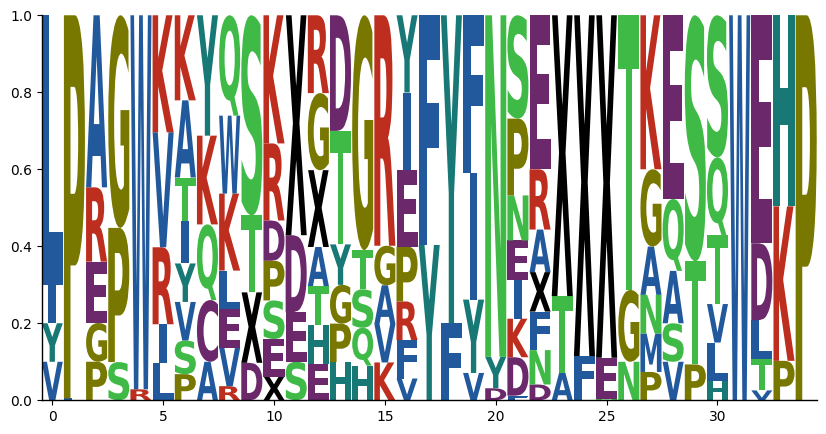

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,2500, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10


Epoch 1/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.29samples/s]

Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.29samples/s, loss=975.9415893554688]

Epoch 1/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20samples/s, loss=975.9415893554688]

Epoch 2/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=1073.663818359375]

Epoch 2/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1073.663818359375]

Epoch 3/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 3/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s]

Epoch 3/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.21samples/s, loss=1074.4974365234375]

Epoch 3/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85samples/s, loss=1074.4974365234375]

Epoch 4/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 4/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 4/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=1060.3101806640625]

Epoch 4/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=1060.3101806640625]

Epoch 5/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 5/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77samples/s]

Epoch 5/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77samples/s, loss=1024.7291259765625]

Epoch 5/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1024.7291259765625]

Epoch 6/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 6/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 6/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=1015.8347778320312]

Epoch 6/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1015.8347778320312]

Epoch 7/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76samples/s]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76samples/s, loss=967.9163208007812]

Epoch 7/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.04samples/s, loss=967.9163208007812]

Epoch 8/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 8/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s]

Epoch 8/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.30samples/s, loss=1010.9799194335938]

Epoch 8/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84samples/s, loss=1010.9799194335938]

Epoch 9/1000:   0%|                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?samples/s]

Epoch 9/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 9/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=1002.3794555664062]

Epoch 9/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=1002.3794555664062]

Epoch 10/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=993.5784912109375]

Epoch 10/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=993.5784912109375]

Epoch 11/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 11/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 11/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=975.1836547851562]

Epoch 11/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=975.1836547851562]

Epoch 12/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=977.0075073242188]

Epoch 12/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=977.0075073242188]

Epoch 13/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 13/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 13/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=1009.5739135742188]

Epoch 13/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1009.5739135742188]

Epoch 14/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 14/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 14/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=1022.6109008789062]

Epoch 14/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=1022.6109008789062]

Epoch 15/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 15/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=1051.59228515625]

Epoch 15/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=1051.59228515625]

Epoch 16/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 16/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 16/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=1036.021484375]

Epoch 16/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=1036.021484375]

Epoch 17/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=956.9466552734375]

Epoch 17/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=956.9466552734375]

Epoch 18/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=999.6634521484375]

Epoch 18/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=999.6634521484375]

Epoch 19/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=970.7330322265625]

Epoch 19/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24samples/s, loss=970.7330322265625]

Epoch 20/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=981.6798706054688]

Epoch 20/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=981.6798706054688]

Epoch 21/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 21/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 21/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=1009.8650512695312]

Epoch 21/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=1009.8650512695312]

Epoch 22/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 22/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 22/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=1012.37353515625]

Epoch 22/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=1012.37353515625]

Epoch 23/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 23/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 23/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=1025.0076904296875]

Epoch 23/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1025.0076904296875]

Epoch 24/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 24/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 24/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=1022.8692626953125]

Epoch 24/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1022.8692626953125]

Epoch 25/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=1013.207763671875]

Epoch 25/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1013.207763671875]

Epoch 26/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 26/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 26/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=1027.523681640625]

Epoch 26/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1027.523681640625]

Epoch 27/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=1002.023681640625]

Epoch 27/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=1002.023681640625]

Epoch 28/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=994.4473876953125]

Epoch 28/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=994.4473876953125]

Epoch 29/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 29/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 29/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=984.3486938476562]

Epoch 29/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=984.3486938476562]

Epoch 30/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61samples/s]

Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61samples/s, loss=965.9990844726562]

Epoch 30/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14samples/s, loss=965.9990844726562]

Epoch 31/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 31/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 31/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=984.455322265625]

Epoch 31/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=984.455322265625]

Epoch 32/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 32/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 32/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=1001.2077026367188]

Epoch 32/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1001.2077026367188]

Epoch 33/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 33/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 33/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=1010.9835205078125]

Epoch 33/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1010.9835205078125]

Epoch 34/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=986.6373291015625]

Epoch 34/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=986.6373291015625]

Epoch 35/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 35/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 35/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=985.6371459960938]

Epoch 35/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=985.6371459960938]

Epoch 36/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=976.9595336914062]

Epoch 36/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=976.9595336914062]

Epoch 37/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=970.0589599609375]

Epoch 37/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=970.0589599609375]

Epoch 38/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 38/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 38/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=940.0435791015625]

Epoch 38/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=940.0435791015625]

Epoch 39/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=946.5169067382812]

Epoch 39/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=946.5169067382812]

Epoch 40/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=963.2723388671875]

Epoch 40/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=963.2723388671875]

Epoch 41/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=958.1626586914062]

Epoch 41/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=958.1626586914062]

Epoch 42/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=946.431640625]

Epoch 42/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=946.431640625]

Epoch 43/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 43/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 43/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=922.607177734375]

Epoch 43/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=922.607177734375]

Epoch 44/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=925.4396362304688]

Epoch 44/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=925.4396362304688]

Epoch 45/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=935.443359375]

Epoch 45/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=935.443359375]

Epoch 46/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=934.5645141601562]

Epoch 46/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=934.5645141601562]

Epoch 47/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 47/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=940.369873046875]

Epoch 47/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=940.369873046875]

Epoch 48/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=930.4575805664062]

Epoch 48/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=930.4575805664062]

Epoch 49/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 49/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 49/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=930.37060546875]

Epoch 49/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=930.37060546875]

Epoch 50/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=899.1983032226562]

Epoch 50/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=899.1983032226562]

Epoch 51/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=935.4874877929688]

Epoch 51/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=935.4874877929688]

Epoch 52/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 52/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 52/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=919.2060546875]

Epoch 52/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=919.2060546875]

Epoch 53/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 53/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=922.068115234375]

Epoch 53/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=922.068115234375]

Epoch 54/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=911.8773193359375]

Epoch 54/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=911.8773193359375]

Epoch 55/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.72samples/s]

Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.72samples/s, loss=896.708984375]

Epoch 55/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=896.708984375]

Epoch 56/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 56/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 56/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=904.5458984375]

Epoch 56/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=904.5458984375]

Epoch 57/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=906.7794799804688]

Epoch 57/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=906.7794799804688]

Epoch 58/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=909.4749145507812]

Epoch 58/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=909.4749145507812]

Epoch 59/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=915.0323486328125]

Epoch 59/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=915.0323486328125]

Epoch 60/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=920.2272338867188]

Epoch 60/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=920.2272338867188]

Epoch 61/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 61/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 61/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=931.7100830078125]

Epoch 61/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=931.7100830078125]

Epoch 62/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 62/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 62/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=906.28271484375]

Epoch 62/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=906.28271484375]

Epoch 63/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 63/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 63/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=914.0818481445312]

Epoch 63/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=914.0818481445312]

Epoch 64/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 64/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 64/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=912.4080810546875]

Epoch 64/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=912.4080810546875]

Epoch 65/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=904.3731689453125]

Epoch 65/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=904.3731689453125]

Epoch 66/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 66/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 66/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=900.101318359375]

Epoch 66/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=900.101318359375]

Epoch 67/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=903.9163818359375]

Epoch 67/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=903.9163818359375]

Epoch 68/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=900.3513793945312]

Epoch 68/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=900.3513793945312]

Epoch 69/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=900.9497680664062]

Epoch 69/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=900.9497680664062]

Epoch 70/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 70/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=909.532470703125]

Epoch 70/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=909.532470703125]

Epoch 71/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=902.0475463867188]

Epoch 71/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=902.0475463867188]

Epoch 72/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 72/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 72/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=908.1064453125]

Epoch 72/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=908.1064453125]

Epoch 73/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=887.3775024414062]

Epoch 73/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=887.3775024414062]

Epoch 74/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=894.5588989257812]

Epoch 74/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=894.5588989257812]

Epoch 75/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=901.9682006835938]

Epoch 75/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=901.9682006835938]

Epoch 76/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 76/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 76/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=908.4383544921875]

Epoch 76/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=908.4383544921875]

Epoch 77/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 77/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 77/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=895.318359375]

Epoch 77/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=895.318359375]

Epoch 78/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=903.6471557617188]

Epoch 78/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=903.6471557617188]

Epoch 79/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=885.7709350585938]

Epoch 79/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=885.7709350585938]

Epoch 80/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=902.2643432617188]

Epoch 80/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=902.2643432617188]

Epoch 81/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 81/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=902.690673828125]

Epoch 81/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=902.690673828125]

Epoch 82/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=905.3827514648438]

Epoch 82/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=905.3827514648438]

Epoch 83/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=894.0142822265625]

Epoch 83/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=894.0142822265625]

Epoch 84/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=884.7449340820312]

Epoch 84/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=884.7449340820312]

Epoch 85/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 85/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.79samples/s]

Epoch 85/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.79samples/s, loss=876.3583984375]

Epoch 85/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=876.3583984375]

Epoch 86/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=890.7479858398438]

Epoch 86/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=890.7479858398438]

Epoch 87/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 87/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 87/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=887.1524047851562]

Epoch 87/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=887.1524047851562]

Epoch 88/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 88/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 88/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=877.957275390625]

Epoch 88/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=877.957275390625]

Epoch 89/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 89/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 89/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=877.1821899414062]

Epoch 89/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=877.1821899414062]

Epoch 90/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 90/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 90/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=881.804443359375]

Epoch 90/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=881.804443359375]

Epoch 91/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 91/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 91/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=878.2217407226562]

Epoch 91/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=878.2217407226562]

Epoch 92/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 92/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 92/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=876.744140625]

Epoch 92/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=876.744140625]

Epoch 93/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=889.6248779296875]

Epoch 93/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=889.6248779296875]

Epoch 94/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 94/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 94/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=877.09814453125]

Epoch 94/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=877.09814453125]

Epoch 95/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=876.1106567382812]

Epoch 95/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=876.1106567382812]

Epoch 96/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=876.3573608398438]

Epoch 96/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=876.3573608398438]

Epoch 97/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=882.3220825195312]

Epoch 97/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=882.3220825195312]

Epoch 98/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 98/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=871.215087890625]

Epoch 98/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=871.215087890625]

Epoch 99/1000:   0%|                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?samples/s]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=874.9664916992188]

Epoch 99/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=874.9664916992188]

Epoch 100/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=868.4220581054688]

Epoch 100/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=868.4220581054688]

Epoch 101/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=868.4187622070312]

Epoch 101/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=868.4187622070312]

Epoch 102/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 102/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=873.47265625]

Epoch 102/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=873.47265625]

Epoch 103/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 103/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s]

Epoch 103/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s, loss=880.706298828125]

Epoch 103/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=880.706298828125]

Epoch 104/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 104/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 104/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=859.693359375]

Epoch 104/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.21samples/s, loss=859.693359375]

Epoch 105/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=882.8082885742188]

Epoch 105/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=882.8082885742188]

Epoch 106/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=872.0932006835938]

Epoch 106/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=872.0932006835938]

Epoch 107/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=867.1846313476562]

Epoch 107/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=867.1846313476562]

Epoch 108/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=860.0399169921875]

Epoch 108/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=860.0399169921875]

Epoch 109/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 109/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 109/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=866.24951171875]

Epoch 109/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=866.24951171875]

Epoch 110/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=875.8313598632812]

Epoch 110/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=875.8313598632812]

Epoch 111/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=859.275390625]

Epoch 111/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=859.275390625]

Epoch 112/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=858.9352416992188]

Epoch 112/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=858.9352416992188]

Epoch 113/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=855.2269287109375]

Epoch 113/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=855.2269287109375]

Epoch 114/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=854.6840209960938]

Epoch 114/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=854.6840209960938]

Epoch 115/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=856.2500610351562]

Epoch 115/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=856.2500610351562]

Epoch 116/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 116/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 116/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=853.944091796875]

Epoch 116/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=853.944091796875]

Epoch 117/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 117/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 117/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=853.6139526367188]

Epoch 117/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=853.6139526367188]

Epoch 118/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=846.7579345703125]

Epoch 118/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=846.7579345703125]

Epoch 119/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=854.3810424804688]

Epoch 119/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=854.3810424804688]

Epoch 120/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=845.7012329101562]

Epoch 120/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=845.7012329101562]

Epoch 121/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 121/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 121/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=843.869140625]

Epoch 121/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=843.869140625]

Epoch 122/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=836.6560668945312]

Epoch 122/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=836.6560668945312]

Epoch 123/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s, loss=845.2381591796875]

Epoch 123/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=845.2381591796875]

Epoch 124/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=839.7626342773438]

Epoch 124/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=839.7626342773438]

Epoch 125/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 125/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 125/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=831.82470703125]

Epoch 125/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=831.82470703125]

Epoch 126/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=836.2093505859375]

Epoch 126/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=836.2093505859375]

Epoch 127/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=851.0261840820312]

Epoch 127/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=851.0261840820312]

Epoch 128/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 128/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 128/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=836.320556640625]

Epoch 128/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=836.320556640625]

Epoch 129/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=848.8451538085938]

Epoch 129/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=848.8451538085938]

Epoch 130/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80samples/s]

Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80samples/s, loss=835.9129028320312]

Epoch 130/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=835.9129028320312]

Epoch 131/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s]

Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.42samples/s, loss=852.1854248046875]

Epoch 131/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=852.1854248046875]

Epoch 132/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=838.9884033203125]

Epoch 132/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=838.9884033203125]

Epoch 133/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.64samples/s]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.64samples/s, loss=833.6812133789062]

Epoch 133/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.11samples/s, loss=833.6812133789062]

Epoch 134/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 134/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 134/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=850.91552734375]

Epoch 134/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=850.91552734375]

Epoch 135/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 135/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=834.994384765625]

Epoch 135/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=834.994384765625]

Epoch 136/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=827.6793212890625]

Epoch 136/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=827.6793212890625]

Epoch 137/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s]

Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=833.0357666015625]

Epoch 137/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.09samples/s, loss=833.0357666015625]

Epoch 138/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s]

Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s, loss=837.7465209960938]

Epoch 138/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=837.7465209960938]

Epoch 139/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 139/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 139/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=824.5040893554688]

Epoch 139/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=824.5040893554688]

Epoch 140/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.29samples/s, loss=843.0073852539062]

Epoch 140/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.92samples/s, loss=843.0073852539062]

Epoch 141/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 141/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=830.020751953125]

Epoch 141/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=830.020751953125]

Epoch 142/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=830.5781860351562]

Epoch 142/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=830.5781860351562]

Epoch 143/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=831.1270141601562]

Epoch 143/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=831.1270141601562]

Epoch 144/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=831.5214233398438]

Epoch 144/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=831.5214233398438]

Epoch 145/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s]

Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s, loss=821.8994750976562]

Epoch 145/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=821.8994750976562]

Epoch 146/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=829.9243774414062]

Epoch 146/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.32samples/s, loss=829.9243774414062]

Epoch 147/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=838.3206176757812]

Epoch 147/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=838.3206176757812]

Epoch 148/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.69samples/s]

Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.69samples/s, loss=827.5386352539062]

Epoch 148/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=827.5386352539062]

Epoch 149/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=829.7911987304688]

Epoch 149/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=829.7911987304688]

Epoch 150/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s, loss=823.8829956054688]

Epoch 150/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=823.8829956054688]

Epoch 151/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=819.8009033203125]

Epoch 151/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=819.8009033203125]

Epoch 152/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 152/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 152/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=820.43408203125]

Epoch 152/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=820.43408203125]

Epoch 153/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 153/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=826.696044921875]

Epoch 153/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=826.696044921875]

Epoch 154/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 154/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=828.822021484375]

Epoch 154/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=828.822021484375]

Epoch 155/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=815.7337036132812]

Epoch 155/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=815.7337036132812]

Epoch 156/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 156/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 156/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=827.14013671875]

Epoch 156/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=827.14013671875]

Epoch 157/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 157/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 157/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=824.443603515625]

Epoch 157/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=824.443603515625]

Epoch 158/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=815.1356811523438]

Epoch 158/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=815.1356811523438]

Epoch 159/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=821.9882202148438]

Epoch 159/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=821.9882202148438]

Epoch 160/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=814.7067260742188]

Epoch 160/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=814.7067260742188]

Epoch 161/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=826.8885498046875]

Epoch 161/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=826.8885498046875]

Epoch 162/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 162/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76samples/s]

Epoch 162/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76samples/s, loss=820.152099609375]

Epoch 162/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.22samples/s, loss=820.152099609375]

Epoch 163/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 163/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s]

Epoch 163/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47samples/s, loss=819.09033203125]

Epoch 163/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.07samples/s, loss=819.09033203125]

Epoch 164/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=820.3363647460938]

Epoch 164/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.30samples/s, loss=820.3363647460938]

Epoch 165/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 165/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74samples/s]

Epoch 165/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74samples/s, loss=817.1407470703125]

Epoch 165/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=817.1407470703125]

Epoch 166/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s]

Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s, loss=819.4142456054688]

Epoch 166/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.38samples/s, loss=819.4142456054688]

Epoch 167/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 167/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=812.58349609375]

Epoch 167/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=812.58349609375]

Epoch 168/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 168/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 168/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=818.56396484375]

Epoch 168/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=818.56396484375]

Epoch 169/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 169/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 169/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=815.7320556640625]

Epoch 169/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=815.7320556640625]

Epoch 170/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=811.6271362304688]

Epoch 170/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=811.6271362304688]

Epoch 171/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 171/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 171/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=811.2612915039062]

Epoch 171/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=811.2612915039062]

Epoch 172/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 172/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 172/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=813.982666015625]

Epoch 172/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=813.982666015625]

Epoch 173/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=815.7967529296875]

Epoch 173/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=815.7967529296875]

Epoch 174/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=810.5023193359375]

Epoch 174/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=810.5023193359375]

Epoch 175/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 175/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77samples/s]

Epoch 175/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.77samples/s, loss=822.4560546875]

Epoch 175/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=822.4560546875]

Epoch 176/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 176/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 176/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=819.5135498046875]

Epoch 176/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=819.5135498046875]

Epoch 177/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 177/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=838.539794921875]

Epoch 177/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=838.539794921875]

Epoch 178/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 178/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 178/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=815.9019165039062]

Epoch 178/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=815.9019165039062]

Epoch 179/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=815.6027221679688]

Epoch 179/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=815.6027221679688]

Epoch 180/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=830.1905517578125]

Epoch 180/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=830.1905517578125]

Epoch 181/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=815.1358032226562]

Epoch 181/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=815.1358032226562]

Epoch 182/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 182/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 182/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=836.93701171875]

Epoch 182/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=836.93701171875]

Epoch 183/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 183/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 183/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=816.539794921875]

Epoch 183/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=816.539794921875]

Epoch 184/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 184/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=836.906982421875]

Epoch 184/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=836.906982421875]

Epoch 185/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 185/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 185/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=811.4060668945312]

Epoch 185/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=811.4060668945312]

Epoch 186/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=819.8062744140625]

Epoch 186/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=819.8062744140625]

Epoch 187/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=815.4551391601562]

Epoch 187/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=815.4551391601562]

Epoch 188/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=820.3804321289062]

Epoch 188/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=820.3804321289062]

Epoch 189/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=817.8082885742188]

Epoch 189/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=817.8082885742188]

Epoch 190/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 190/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 190/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=819.3528442382812]

Epoch 190/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=819.3528442382812]

Epoch 191/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 191/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 191/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=812.3920288085938]

Epoch 191/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=812.3920288085938]

Epoch 192/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 192/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 192/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=813.9345703125]

Epoch 192/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=813.9345703125]

Epoch 193/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 193/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 193/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=809.9296264648438]

Epoch 193/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=809.9296264648438]

Epoch 194/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=815.8246459960938]

Epoch 194/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=815.8246459960938]

Epoch 195/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=815.1349487304688]

Epoch 195/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=815.1349487304688]

Epoch 196/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 196/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 196/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=811.84423828125]

Epoch 196/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=811.84423828125]

Epoch 197/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=828.0839233398438]

Epoch 197/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=828.0839233398438]

Epoch 198/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=811.7772827148438]

Epoch 198/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=811.7772827148438]

Epoch 199/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=823.9880981445312]

Epoch 199/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=823.9880981445312]

Epoch 200/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=815.3381958007812]

Epoch 200/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=815.3381958007812]

Epoch 201/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 201/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 201/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=828.2119140625]

Epoch 201/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=828.2119140625]

Epoch 202/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 202/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 202/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=809.33935546875]

Epoch 202/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=809.33935546875]

Epoch 203/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=823.6370849609375]

Epoch 203/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=823.6370849609375]

Epoch 204/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=811.0543212890625]

Epoch 204/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=811.0543212890625]

Epoch 205/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

From Here


Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=816.1116333007812]

Epoch 205/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=816.1116333007812]

Epoch 206/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=808.3226318359375]

Epoch 206/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=808.3226318359375]

Epoch 207/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=812.7289428710938]

Epoch 207/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=812.7289428710938]

Epoch 208/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.51samples/s, loss=810.9342041015625]

Epoch 208/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.12samples/s, loss=810.9342041015625]

Epoch 209/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=811.0213623046875]

Epoch 209/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=811.0213623046875]

Epoch 210/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=806.7701416015625]

Epoch 210/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=806.7701416015625]

Epoch 211/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 211/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 211/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=808.28662109375]

Epoch 211/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=808.28662109375]

Epoch 212/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 212/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 212/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=811.4788208007812]

Epoch 212/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=811.4788208007812]

Epoch 213/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=806.5047607421875]

Epoch 213/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=806.5047607421875]

Epoch 214/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 214/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 214/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=806.9765625]

Epoch 214/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=806.9765625]

Epoch 215/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=807.9705200195312]

Epoch 215/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=807.9705200195312]

Epoch 216/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 216/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 216/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=810.4867553710938]

Epoch 216/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=810.4867553710938]

Epoch 217/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 217/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 217/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=806.2705078125]

Epoch 217/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=806.2705078125]

Epoch 218/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=808.8892211914062]

Epoch 218/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=808.8892211914062]

Epoch 219/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=808.0578002929688]

Epoch 219/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=808.0578002929688]

Epoch 220/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 220/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 220/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=806.9436645507812]

Epoch 220/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=806.9436645507812]

Epoch 221/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 221/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 221/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=810.63671875]

Epoch 221/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=810.63671875]

Epoch 222/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=807.1257934570312]

Epoch 222/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=807.1257934570312]

Epoch 223/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=806.9391479492188]

Epoch 223/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=806.9391479492188]

Epoch 224/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 224/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 224/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=813.2626953125]

Epoch 224/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=813.2626953125]

Epoch 225/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 225/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 225/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=810.0040893554688]

Epoch 225/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=810.0040893554688]

Epoch 226/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=807.5111694335938]

Epoch 226/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=807.5111694335938]

Epoch 227/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 227/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 227/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=807.1053466796875]

Epoch 227/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=807.1053466796875]

Epoch 228/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=807.6646728515625]

Epoch 228/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=807.6646728515625]

Epoch 229/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=806.0328369140625]

Epoch 229/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=806.0328369140625]

Epoch 230/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=805.1854858398438]

Epoch 230/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=805.1854858398438]

Epoch 231/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=807.0501098632812]

Epoch 231/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=807.0501098632812]

Epoch 232/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=812.5099487304688]

Epoch 232/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=812.5099487304688]

Epoch 233/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 233/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=805.926513671875]

Epoch 233/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.926513671875]

Epoch 234/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=806.0885620117188]

Epoch 234/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=806.0885620117188]

Epoch 235/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 235/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 235/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=804.7662963867188]

Epoch 235/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=804.7662963867188]

Epoch 236/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=805.2737426757812]

Epoch 236/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.2737426757812]

Epoch 237/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=807.3197631835938]

Epoch 237/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=807.3197631835938]

Epoch 238/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=807.1039428710938]

Epoch 238/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=807.1039428710938]

Epoch 239/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=805.8289794921875]

Epoch 239/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=805.8289794921875]

Epoch 240/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=804.5066528320312]

Epoch 240/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=804.5066528320312]

Epoch 241/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 241/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 241/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=806.1914672851562]

Epoch 241/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=806.1914672851562]

Epoch 242/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 242/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 242/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=810.90673828125]

Epoch 242/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=810.90673828125]

Epoch 243/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 243/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=813.409423828125]

Epoch 243/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=813.409423828125]

Epoch 244/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 244/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 244/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=806.0584106445312]

Epoch 244/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=806.0584106445312]

Epoch 245/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 245/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=804.254150390625]

Epoch 245/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=804.254150390625]

Epoch 246/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 246/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 246/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=807.3887329101562]

Epoch 246/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=807.3887329101562]

Epoch 247/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=806.4226684570312]

Epoch 247/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=806.4226684570312]

Epoch 248/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=806.8036499023438]

Epoch 248/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=806.8036499023438]

Epoch 249/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 249/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 249/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=817.7964477539062]

Epoch 249/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=817.7964477539062]

Epoch 250/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 250/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 250/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=805.8534545898438]

Epoch 250/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=805.8534545898438]

Epoch 251/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 251/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 251/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=812.4716796875]

Epoch 251/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=812.4716796875]

Epoch 252/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=829.8211059570312]

Epoch 252/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=829.8211059570312]

Epoch 253/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 253/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 253/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=809.8203125]

Epoch 253/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=809.8203125]

Epoch 254/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=808.9276123046875]

Epoch 254/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=808.9276123046875]

Epoch 255/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=823.9251708984375]

Epoch 255/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=823.9251708984375]

Epoch 256/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 256/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 256/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=811.7080078125]

Epoch 256/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=811.7080078125]

Epoch 257/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=811.6287841796875]

Epoch 257/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=811.6287841796875]

Epoch 258/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=816.5078735351562]

Epoch 258/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=816.5078735351562]

Epoch 259/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 259/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 259/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=804.306884765625]

Epoch 259/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=804.306884765625]

Epoch 260/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=811.9049072265625]

Epoch 260/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=811.9049072265625]

Epoch 261/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=809.6590576171875]

Epoch 261/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=809.6590576171875]

Epoch 262/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=807.6825561523438]

Epoch 262/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=807.6825561523438]

Epoch 263/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=810.4839477539062]

Epoch 263/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=810.4839477539062]

Epoch 264/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 264/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 264/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=805.439453125]

Epoch 264/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=805.439453125]

Epoch 265/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 265/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 265/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=806.9921875]

Epoch 265/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=806.9921875]

Epoch 266/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 266/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 266/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=812.4320068359375]

Epoch 266/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=812.4320068359375]

Epoch 267/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 267/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 267/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=804.959716796875]

Epoch 267/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=804.959716796875]

Epoch 268/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 268/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 268/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=804.8677978515625]

Epoch 268/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=804.8677978515625]

Epoch 269/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 269/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 269/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=813.3192138671875]

Epoch 269/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=813.3192138671875]

Epoch 270/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=803.7517700195312]

Epoch 270/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.7517700195312]

Epoch 271/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 271/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 271/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=806.7593383789062]

Epoch 271/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=806.7593383789062]

Epoch 272/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=807.3150634765625]

Epoch 272/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.3150634765625]

Epoch 273/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=803.1939086914062]

Epoch 273/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.1939086914062]

Epoch 274/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=806.5681762695312]

Epoch 274/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=806.5681762695312]

Epoch 275/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 275/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 275/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=806.8012084960938]

Epoch 275/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=806.8012084960938]

Epoch 276/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=803.0110473632812]

Epoch 276/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=803.0110473632812]

Epoch 277/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 277/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 277/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=805.894775390625]

Epoch 277/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.894775390625]

Epoch 278/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=806.5750122070312]

Epoch 278/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=806.5750122070312]

Epoch 279/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 279/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 279/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=802.9940795898438]

Epoch 279/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=802.9940795898438]

Epoch 280/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 280/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 280/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=805.3428955078125]

Epoch 280/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.3428955078125]

Epoch 281/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 281/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 281/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=802.58056640625]

Epoch 281/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.58056640625]

Epoch 282/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 282/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 282/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=802.62744140625]

Epoch 282/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.62744140625]

Epoch 283/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 283/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 283/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=804.4702758789062]

Epoch 283/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=804.4702758789062]

Epoch 284/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 284/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 284/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=804.51220703125]

Epoch 284/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.51220703125]

Epoch 285/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=802.3843994140625]

Epoch 285/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.3843994140625]

Epoch 286/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=802.5885009765625]

Epoch 286/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.5885009765625]

Epoch 287/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=802.8298950195312]

Epoch 287/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=802.8298950195312]

Epoch 288/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=803.8617553710938]

Epoch 288/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.8617553710938]

Epoch 289/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 289/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 289/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=803.121337890625]

Epoch 289/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.121337890625]

Epoch 290/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 290/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 290/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=803.3623046875]

Epoch 290/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.3623046875]

Epoch 291/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=802.9317626953125]

Epoch 291/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.9317626953125]

Epoch 292/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 292/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 292/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=802.5639038085938]

Epoch 292/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.5639038085938]

Epoch 293/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=804.6790771484375]

Epoch 293/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=804.6790771484375]

Epoch 294/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 294/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 294/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=805.47021484375]

Epoch 294/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.47021484375]

Epoch 295/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=808.0139770507812]

Epoch 295/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=808.0139770507812]

Epoch 296/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 296/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 296/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=807.6411743164062]

Epoch 296/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=807.6411743164062]

Epoch 297/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=805.1979370117188]

Epoch 297/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=805.1979370117188]

Epoch 298/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 298/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 298/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=803.72998046875]

Epoch 298/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.72998046875]

Epoch 299/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 299/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 299/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=803.2061767578125]

Epoch 299/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=803.2061767578125]

Epoch 300/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 300/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 300/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=807.1551513671875]

Epoch 300/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=807.1551513671875]

Epoch 301/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 301/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 301/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=806.61181640625]

Epoch 301/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=806.61181640625]

Epoch 302/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=811.0626831054688]

Epoch 302/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=811.0626831054688]

Epoch 303/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 303/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=814.055419921875]

Epoch 303/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=814.055419921875]

Epoch 304/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=807.0833129882812]

Epoch 304/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=807.0833129882812]

Epoch 305/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 305/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 305/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=802.05712890625]

Epoch 305/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=802.05712890625]

Epoch 306/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 306/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 306/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=805.1932373046875]

Epoch 306/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=805.1932373046875]

Epoch 307/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 307/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 307/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=810.7452392578125]

Epoch 307/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=810.7452392578125]

Epoch 308/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=807.7650146484375]

Epoch 308/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=807.7650146484375]

Epoch 309/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=803.4603881835938]

Epoch 309/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=803.4603881835938]

Epoch 310/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=801.9542236328125]

Epoch 310/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=801.9542236328125]

Epoch 311/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 311/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=804.302490234375]

Epoch 311/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=804.302490234375]

Epoch 312/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=804.8389282226562]

Epoch 312/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=804.8389282226562]

Epoch 313/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 313/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 313/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=802.4093627929688]

Epoch 313/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=802.4093627929688]

Epoch 314/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 314/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 314/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=802.6055297851562]

Epoch 314/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.6055297851562]

Epoch 315/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 315/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 315/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=801.7890625]

Epoch 315/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=801.7890625]

Epoch 316/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=803.2648315429688]

Epoch 316/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.2648315429688]

Epoch 317/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=801.818359375]

Epoch 317/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=801.818359375]

Epoch 318/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=802.3731689453125]

Epoch 318/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=802.3731689453125]

Epoch 319/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=801.1032104492188]

Epoch 319/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=801.1032104492188]

Epoch 320/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=802.3226318359375]

Epoch 320/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=802.3226318359375]

Epoch 321/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 321/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 321/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=803.45068359375]

Epoch 321/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=803.45068359375]

Epoch 322/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=805.3511352539062]

Epoch 322/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=805.3511352539062]

Epoch 323/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=805.0240478515625]

Epoch 323/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=805.0240478515625]

Epoch 324/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=804.7969970703125]

Epoch 324/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=804.7969970703125]

Epoch 325/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=803.6566772460938]

Epoch 325/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=803.6566772460938]

Epoch 326/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=802.5906372070312]

Epoch 326/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=802.5906372070312]

Epoch 327/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=807.0457153320312]

Epoch 327/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=807.0457153320312]

Epoch 328/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 328/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 328/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=801.7781982421875]

Epoch 328/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.7781982421875]

Epoch 329/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 329/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 329/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=801.6357421875]

Epoch 329/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=801.6357421875]

Epoch 330/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.9715576171875]

Epoch 330/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=801.9715576171875]

Epoch 331/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=802.3428955078125]

Epoch 331/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=802.3428955078125]

Epoch 332/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=802.3865966796875]

Epoch 332/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.3865966796875]

Epoch 333/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=806.5867309570312]

Epoch 333/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=806.5867309570312]

Epoch 334/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=810.1341552734375]

Epoch 334/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=810.1341552734375]

Epoch 335/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=814.2536010742188]

Epoch 335/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=814.2536010742188]

Epoch 336/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=819.1737670898438]

Epoch 336/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=819.1737670898438]

Epoch 337/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=816.4196166992188]

Epoch 337/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=816.4196166992188]

Epoch 338/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=806.3690185546875]

Epoch 338/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=806.3690185546875]

Epoch 339/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 339/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 339/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=802.512939453125]

Epoch 339/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.512939453125]

Epoch 340/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=805.3151245117188]

Epoch 340/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.3151245117188]

Epoch 341/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=809.3812866210938]

Epoch 341/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=809.3812866210938]

Epoch 342/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=804.8424682617188]

Epoch 342/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=804.8424682617188]

Epoch 343/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=801.6234130859375]

Epoch 343/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=801.6234130859375]

Epoch 344/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=804.4422607421875]

Epoch 344/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=804.4422607421875]

Epoch 345/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=808.9489135742188]

Epoch 345/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=808.9489135742188]

Epoch 346/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=803.5969848632812]

Epoch 346/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=803.5969848632812]

Epoch 347/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 347/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58samples/s]

Epoch 347/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58samples/s, loss=802.5452270507812]

Epoch 347/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.17samples/s, loss=802.5452270507812]

Epoch 348/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 348/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 348/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.4265747070312]

Epoch 348/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.4265747070312]

Epoch 349/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 349/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 349/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.8131103515625]

Epoch 349/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.8131103515625]

Epoch 350/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=800.6710815429688]

Epoch 350/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=800.6710815429688]

Epoch 351/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=802.4208374023438]

Epoch 351/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=802.4208374023438]

Epoch 352/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.1421508789062]

Epoch 352/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=801.1421508789062]

Epoch 353/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 353/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 353/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.3825073242188]

Epoch 353/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.3825073242188]

Epoch 354/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=801.7174682617188]

Epoch 354/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=801.7174682617188]

Epoch 355/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=803.4270629882812]

Epoch 355/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=803.4270629882812]

Epoch 356/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=805.2259521484375]

Epoch 356/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.2259521484375]

Epoch 357/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=805.4091186523438]

Epoch 357/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=805.4091186523438]

Epoch 358/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 358/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 358/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=802.074462890625]

Epoch 358/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.074462890625]

Epoch 359/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 359/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 359/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=800.97314453125]

Epoch 359/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=800.97314453125]

Epoch 360/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 360/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 360/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=801.2058715820312]

Epoch 360/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.2058715820312]

Epoch 361/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.1051025390625]

Epoch 361/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=804.1051025390625]

Epoch 362/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=804.8436889648438]

Epoch 362/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=804.8436889648438]

Epoch 363/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.3652954101562]

Epoch 363/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=801.3652954101562]

Epoch 364/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.5851440429688]

Epoch 364/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=800.5851440429688]

Epoch 365/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.9968872070312]

Epoch 365/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.9968872070312]

Epoch 366/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 366/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=801.758544921875]

Epoch 366/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.758544921875]

Epoch 367/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 367/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 367/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=802.4029541015625]

Epoch 367/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=802.4029541015625]

Epoch 368/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 368/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 368/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=802.204833984375]

Epoch 368/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.204833984375]

Epoch 369/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=801.7831420898438]

Epoch 369/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=801.7831420898438]

Epoch 370/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=805.1791381835938]

Epoch 370/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.1791381835938]

Epoch 371/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=806.6973876953125]

Epoch 371/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=806.6973876953125]

Epoch 372/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 372/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 372/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=808.599365234375]

Epoch 372/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=808.599365234375]

Epoch 373/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 373/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 373/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=812.3596801757812]

Epoch 373/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=812.3596801757812]

Epoch 374/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=806.5617065429688]

Epoch 374/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=806.5617065429688]

Epoch 375/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=805.0066528320312]

Epoch 375/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=805.0066528320312]

Epoch 376/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.9368896484375]

Epoch 376/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.9368896484375]

Epoch 377/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=804.6097412109375]

Epoch 377/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=804.6097412109375]

Epoch 378/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=808.1299438476562]

Epoch 378/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=808.1299438476562]

Epoch 379/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=812.1228637695312]

Epoch 379/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=812.1228637695312]

Epoch 380/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=808.220703125]

Epoch 380/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=808.220703125]

Epoch 381/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 381/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=801.892822265625]

Epoch 381/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=801.892822265625]

Epoch 382/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 382/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 382/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=803.3158569335938]

Epoch 382/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=803.3158569335938]

Epoch 383/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=808.3770751953125]

Epoch 383/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=808.3770751953125]

Epoch 384/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=806.1004638671875]

Epoch 384/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=806.1004638671875]

Epoch 385/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 385/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 385/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=800.5294799804688]

Epoch 385/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=800.5294799804688]

Epoch 386/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=805.2296142578125]

Epoch 386/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=805.2296142578125]

Epoch 387/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=810.6771850585938]

Epoch 387/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=810.6771850585938]

Epoch 388/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.2479248046875]

Epoch 388/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=804.2479248046875]

Epoch 389/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=801.1085205078125]

Epoch 389/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.1085205078125]

Epoch 390/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 390/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 390/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=810.4793701171875]

Epoch 390/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=810.4793701171875]

Epoch 391/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=806.7723388671875]

Epoch 391/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=806.7723388671875]

Epoch 392/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.1383056640625]

Epoch 392/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.1383056640625]

Epoch 393/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 393/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 393/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=805.020751953125]

Epoch 393/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.020751953125]

Epoch 394/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=804.6563720703125]

Epoch 394/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.6563720703125]

Epoch 395/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.8795776367188]

Epoch 395/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=801.8795776367188]

Epoch 396/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=801.4196166992188]

Epoch 396/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=801.4196166992188]

Epoch 397/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=804.6299438476562]

Epoch 397/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=804.6299438476562]

Epoch 398/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 398/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 398/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=800.0093383789062]

Epoch 398/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=800.0093383789062]

Epoch 399/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 399/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=802.738037109375]

Epoch 399/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=802.738037109375]

Epoch 400/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=805.263671875]

Epoch 400/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=805.263671875]

Epoch 401/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=800.2587280273438]

Epoch 401/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=800.2587280273438]

Epoch 402/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 402/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 402/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=802.3411865234375]

Epoch 402/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=802.3411865234375]

Epoch 403/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=802.3016357421875]

Epoch 403/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=802.3016357421875]

Epoch 404/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=802.6956176757812]

Epoch 404/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=802.6956176757812]

Epoch 405/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=803.2813110351562]

Epoch 405/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=803.2813110351562]

Epoch 406/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 406/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 406/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=802.76416015625]

Epoch 406/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.76416015625]

Epoch 407/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 407/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 407/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=807.633056640625]

Epoch 407/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=807.633056640625]

Epoch 408/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=808.8541870117188]

Epoch 408/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=808.8541870117188]

Epoch 409/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.5540771484375]

Epoch 409/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.5540771484375]

Epoch 410/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 410/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 410/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=803.840087890625]

Epoch 410/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=803.840087890625]

Epoch 411/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=805.1593627929688]

Epoch 411/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=805.1593627929688]

Epoch 412/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.8715209960938]

Epoch 412/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.8715209960938]

Epoch 413/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.7361450195312]

Epoch 413/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=800.7361450195312]

Epoch 414/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=805.0730590820312]

Epoch 414/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=805.0730590820312]

Epoch 415/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 415/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 415/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=803.8111572265625]

Epoch 415/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=803.8111572265625]

Epoch 416/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61samples/s]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61samples/s, loss=799.8427124023438]

Epoch 416/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=799.8427124023438]

Epoch 417/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 417/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 417/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=801.5424194335938]

Epoch 417/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.5424194335938]

Epoch 418/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 418/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 418/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=806.21533203125]

Epoch 418/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=806.21533203125]

Epoch 419/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=803.4891967773438]

Epoch 419/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=803.4891967773438]

Epoch 420/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 420/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 420/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.5780639648438]

Epoch 420/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.5780639648438]

Epoch 421/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 421/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 421/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=800.6188354492188]

Epoch 421/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=800.6188354492188]

Epoch 422/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.3299560546875]

Epoch 422/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=804.3299560546875]

Epoch 423/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.5341186523438]

Epoch 423/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=804.5341186523438]

Epoch 424/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.5870361328125]

Epoch 424/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=800.5870361328125]

Epoch 425/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.8920288085938]

Epoch 425/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=799.8920288085938]

Epoch 426/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=804.3161010742188]

Epoch 426/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=804.3161010742188]

Epoch 427/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 427/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 427/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=802.460205078125]

Epoch 427/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.460205078125]

Epoch 428/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 428/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 428/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=799.985107421875]

Epoch 428/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.985107421875]

Epoch 429/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=802.5720825195312]

Epoch 429/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.5720825195312]

Epoch 430/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=809.5928955078125]

Epoch 430/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=809.5928955078125]

Epoch 431/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 431/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 431/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=809.858642578125]

Epoch 431/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=809.858642578125]

Epoch 432/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=800.5755615234375]

Epoch 432/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.5755615234375]

Epoch 433/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=802.5428466796875]

Epoch 433/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=802.5428466796875]

Epoch 434/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=808.6267700195312]

Epoch 434/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=808.6267700195312]

Epoch 435/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=806.1281127929688]

Epoch 435/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=806.1281127929688]

Epoch 436/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.9654541015625]

Epoch 436/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=799.9654541015625]

Epoch 437/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 437/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 437/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=803.51953125]

Epoch 437/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=803.51953125]

Epoch 438/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=805.0955200195312]

Epoch 438/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=805.0955200195312]

Epoch 439/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 439/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 439/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=800.81298828125]

Epoch 439/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.29samples/s, loss=800.81298828125]

Epoch 440/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 440/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 440/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=800.332275390625]

Epoch 440/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=800.332275390625]

Epoch 441/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 441/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 441/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=801.9832763671875]

Epoch 441/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=801.9832763671875]

Epoch 442/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=800.9283447265625]

Epoch 442/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=800.9283447265625]

Epoch 443/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=799.9952392578125]

Epoch 443/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=799.9952392578125]

Epoch 444/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 444/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 444/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.595458984375]

Epoch 444/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=799.595458984375]

Epoch 445/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=799.6730346679688]

Epoch 445/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=799.6730346679688]

Epoch 446/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.6310424804688]

Epoch 446/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=799.6310424804688]

Epoch 447/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=799.7134399414062]

Epoch 447/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=799.7134399414062]

Epoch 448/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.2299194335938]

Epoch 448/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=799.2299194335938]

Epoch 449/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.3434448242188]

Epoch 449/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=799.3434448242188]

Epoch 450/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 450/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 450/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=799.3959350585938]

Epoch 450/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=799.3959350585938]

Epoch 451/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 451/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 451/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=800.10595703125]

Epoch 451/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=800.10595703125]

Epoch 452/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=799.2573852539062]

Epoch 452/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.2573852539062]

Epoch 453/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 453/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 453/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=801.4558715820312]

Epoch 453/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=801.4558715820312]

Epoch 454/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=803.3924560546875]

Epoch 454/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=803.3924560546875]

Epoch 455/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 455/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=804.931396484375]

Epoch 455/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=804.931396484375]

Epoch 456/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 456/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 456/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=802.7610473632812]

Epoch 456/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=802.7610473632812]

Epoch 457/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 457/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 457/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=801.8601684570312]

Epoch 457/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=801.8601684570312]

Epoch 458/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 458/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 458/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.3318481445312]

Epoch 458/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=799.3318481445312]

Epoch 459/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=799.5385131835938]

Epoch 459/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=799.5385131835938]

Epoch 460/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=799.3399658203125]

Epoch 460/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=799.3399658203125]

Epoch 461/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=799.1497192382812]

Epoch 461/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=799.1497192382812]

Epoch 462/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=800.5419311523438]

Epoch 462/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=800.5419311523438]

Epoch 463/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 463/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 463/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=801.4053344726562]

Epoch 463/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=801.4053344726562]

Epoch 464/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 464/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 464/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=805.3801879882812]

Epoch 464/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=805.3801879882812]

Epoch 465/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=809.8343505859375]

Epoch 465/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=809.8343505859375]

Epoch 466/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=806.0693969726562]

Epoch 466/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=806.0693969726562]

Epoch 467/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=800.3804931640625]

Epoch 467/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=800.3804931640625]

Epoch 468/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=800.4315185546875]

Epoch 468/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=800.4315185546875]

Epoch 469/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 469/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 469/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=804.8203735351562]

Epoch 469/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=804.8203735351562]

Epoch 470/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=806.6030883789062]

Epoch 470/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=806.6030883789062]

Epoch 471/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=802.7505493164062]

Epoch 471/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=802.7505493164062]

Epoch 472/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.0181274414062]

Epoch 472/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.0181274414062]

Epoch 473/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 473/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 473/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.5682983398438]

Epoch 473/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=799.5682983398438]

Epoch 474/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.5452880859375]

Epoch 474/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.5452880859375]

Epoch 475/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.0211181640625]

Epoch 475/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.0211181640625]

Epoch 476/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.7551879882812]

Epoch 476/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=799.7551879882812]

Epoch 477/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=799.6109008789062]

Epoch 477/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.6109008789062]

Epoch 478/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=800.0451049804688]

Epoch 478/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=800.0451049804688]

Epoch 479/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=803.5153198242188]

Epoch 479/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=803.5153198242188]

Epoch 480/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 480/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 480/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.9491577148438]

Epoch 480/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.9491577148438]

Epoch 481/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 481/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 481/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=799.1708984375]

Epoch 481/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.1708984375]

Epoch 482/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 482/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 482/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.473876953125]

Epoch 482/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.473876953125]

Epoch 483/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=799.7785034179688]

Epoch 483/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=799.7785034179688]

Epoch 484/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 484/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 484/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=801.1981811523438]

Epoch 484/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=801.1981811523438]

Epoch 485/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.53samples/s, loss=799.8312377929688]

Epoch 485/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.15samples/s, loss=799.8312377929688]

Epoch 486/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 486/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=800.555908203125]

Epoch 486/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.555908203125]

Epoch 487/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 487/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 487/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=802.1024780273438]

Epoch 487/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=802.1024780273438]

Epoch 488/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 488/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=804.021240234375]

Epoch 488/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=804.021240234375]

Epoch 489/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=802.3806762695312]

Epoch 489/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=802.3806762695312]

Epoch 490/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 490/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 490/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=799.9740600585938]

Epoch 490/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=799.9740600585938]

Epoch 491/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=806.1905517578125]

Epoch 491/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=806.1905517578125]

Epoch 492/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=812.1412963867188]

Epoch 492/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=812.1412963867188]

Epoch 493/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=806.4451904296875]

Epoch 493/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=806.4451904296875]

Epoch 494/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=800.2384643554688]

Epoch 494/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=800.2384643554688]

Epoch 495/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 495/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 495/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=802.0847778320312]

Epoch 495/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=802.0847778320312]

Epoch 496/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=809.2429809570312]

Epoch 496/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=809.2429809570312]

Epoch 497/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=801.7090454101562]

Epoch 497/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=801.7090454101562]

Epoch 498/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=802.123046875]

Epoch 498/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=802.123046875]

Epoch 499/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=807.1060791015625]

Epoch 499/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=807.1060791015625]

Epoch 500/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=806.3980712890625]

Epoch 500/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=806.3980712890625]

Epoch 501/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 501/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 501/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=800.2396240234375]

Epoch 501/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=800.2396240234375]

Epoch 502/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 502/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 502/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=804.77587890625]

Epoch 502/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=804.77587890625]

Epoch 503/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=808.0219116210938]

Epoch 503/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=808.0219116210938]

Epoch 504/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=801.1668701171875]

Epoch 504/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=801.1668701171875]

Epoch 505/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 505/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 505/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=800.98876953125]

Epoch 505/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=800.98876953125]

Epoch 506/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=806.6202392578125]

Epoch 506/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=806.6202392578125]

Epoch 507/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 507/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 507/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=802.8086547851562]

Epoch 507/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=802.8086547851562]

Epoch 508/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 508/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 508/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.890869140625]

Epoch 508/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=799.890869140625]

Epoch 509/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 509/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=803.275146484375]

Epoch 509/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=803.275146484375]

Epoch 510/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 510/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 510/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=804.176513671875]

Epoch 510/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=804.176513671875]

Epoch 511/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 511/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.325927734375]

Epoch 511/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=799.325927734375]

Epoch 512/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=800.2845458984375]

Epoch 512/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=800.2845458984375]

Epoch 513/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 513/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 513/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=803.68603515625]

Epoch 513/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=803.68603515625]

Epoch 514/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 514/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 514/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=803.3781127929688]

Epoch 514/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=803.3781127929688]

Epoch 515/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=799.3074951171875]

Epoch 515/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=799.3074951171875]

Epoch 516/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=802.3736572265625]

Epoch 516/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=802.3736572265625]

Epoch 517/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 517/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 517/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=801.886474609375]

Epoch 517/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=801.886474609375]

Epoch 518/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 518/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 518/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=801.1331176757812]

Epoch 518/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=801.1331176757812]

Epoch 519/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=799.6143798828125]

Epoch 519/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.6143798828125]

Epoch 520/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 520/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 520/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=802.1257934570312]

Epoch 520/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=802.1257934570312]

Epoch 521/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 521/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 521/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=804.1661376953125]

Epoch 521/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=804.1661376953125]

Epoch 522/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=801.0555419921875]

Epoch 522/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=801.0555419921875]

Epoch 523/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=798.861328125]

Epoch 523/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=798.861328125]

Epoch 524/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=800.2073364257812]

Epoch 524/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=800.2073364257812]

Epoch 525/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=800.8216552734375]

Epoch 525/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=800.8216552734375]

Epoch 526/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=799.1079711914062]

Epoch 526/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.1079711914062]

Epoch 527/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=798.9068603515625]

Epoch 527/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=798.9068603515625]

Epoch 528/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 528/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 528/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=799.678955078125]

Epoch 528/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=799.678955078125]

Epoch 529/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=799.1268310546875]

Epoch 529/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.1268310546875]

Epoch 530/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=798.7609252929688]

Epoch 530/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=798.7609252929688]

Epoch 531/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=799.3261108398438]

Epoch 531/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.3261108398438]

Epoch 532/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 532/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 532/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=799.50390625]

Epoch 532/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=799.50390625]

Epoch 533/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=799.9789428710938]

Epoch 533/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=799.9789428710938]

Epoch 534/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 534/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 534/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=798.870849609375]

Epoch 534/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=798.870849609375]

Epoch 535/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=799.8362426757812]

Epoch 535/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=799.8362426757812]

Epoch 536/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=802.9791259765625]

Epoch 536/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=802.9791259765625]

Epoch 537/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 537/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 537/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=805.6048583984375]

Epoch 537/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=805.6048583984375]

Epoch 538/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 538/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s]

Epoch 538/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.57samples/s, loss=804.0802001953125]

Epoch 538/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13samples/s, loss=804.0802001953125]

Epoch 539/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73samples/s]

Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73samples/s, loss=799.2127075195312]

Epoch 539/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.26samples/s, loss=799.2127075195312]

Epoch 540/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 540/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s]

Epoch 540/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.89samples/s, loss=800.0767822265625]

Epoch 540/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=800.0767822265625]

Epoch 541/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 541/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58samples/s]

Epoch 541/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58samples/s, loss=802.1865234375]

Epoch 541/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.16samples/s, loss=802.1865234375]

Epoch 542/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 542/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 542/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=799.6810913085938]

Epoch 542/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=799.6810913085938]

Epoch 543/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 543/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 543/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=803.5458984375]

Epoch 543/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=803.5458984375]

Epoch 544/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 544/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 544/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=808.4573364257812]

Epoch 544/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=808.4573364257812]

Epoch 545/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 545/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 545/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=802.87744140625]

Epoch 545/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=802.87744140625]

Epoch 546/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.2601318359375]

Epoch 546/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=799.2601318359375]

Epoch 547/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=804.0272216796875]

Epoch 547/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=804.0272216796875]

Epoch 548/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 548/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 548/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=810.4010620117188]

Epoch 548/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=810.4010620117188]

Epoch 549/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 549/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 549/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=801.91455078125]

Epoch 549/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=801.91455078125]

Epoch 550/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=800.0353393554688]

Epoch 550/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=800.0353393554688]

Epoch 551/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=806.2864990234375]

Epoch 551/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=806.2864990234375]

Epoch 552/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 552/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 552/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=808.0132446289062]

Epoch 552/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=808.0132446289062]

Epoch 553/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.6835327148438]

Epoch 553/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=800.6835327148438]

Epoch 554/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.78samples/s]

Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.78samples/s, loss=801.6994018554688]

Epoch 554/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33samples/s, loss=801.6994018554688]

Epoch 555/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=807.4779663085938]

Epoch 555/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=807.4779663085938]

Epoch 556/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=803.8480224609375]

Epoch 556/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=803.8480224609375]

Epoch 557/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=799.2470092773438]

Epoch 557/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=799.2470092773438]

Epoch 558/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=802.8768310546875]

Epoch 558/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.8768310546875]

Epoch 559/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 559/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=802.758544921875]

Epoch 559/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.758544921875]

Epoch 560/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 560/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=799.567138671875]

Epoch 560/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=799.567138671875]

Epoch 561/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=800.2852783203125]

Epoch 561/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.2852783203125]

Epoch 562/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=804.0340576171875]

Epoch 562/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.0340576171875]

Epoch 563/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 563/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 563/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=800.5772705078125]

Epoch 563/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=800.5772705078125]

Epoch 564/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.3571166992188]

Epoch 564/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=799.3571166992188]

Epoch 565/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s]

Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20samples/s, loss=803.2840576171875]

Epoch 565/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=803.2840576171875]

Epoch 566/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 566/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 566/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=802.8131103515625]

Epoch 566/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.8131103515625]

Epoch 567/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=799.0984497070312]

Epoch 567/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=799.0984497070312]

Epoch 568/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=802.0968627929688]

Epoch 568/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=802.0968627929688]

Epoch 569/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 569/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=802.393310546875]

Epoch 569/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.393310546875]

Epoch 570/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 570/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 570/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.7526245117188]

Epoch 570/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=799.7526245117188]

Epoch 571/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 571/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 571/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=799.8265380859375]

Epoch 571/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=799.8265380859375]

Epoch 572/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=802.3726196289062]

Epoch 572/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=802.3726196289062]

Epoch 573/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=801.7568969726562]

Epoch 573/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=801.7568969726562]

Epoch 574/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=799.0621948242188]

Epoch 574/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.0621948242188]

Epoch 575/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s, loss=799.4288330078125]

Epoch 575/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.4288330078125]

Epoch 576/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=799.7816772460938]

Epoch 576/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.7816772460938]

Epoch 577/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=799.2579345703125]

Epoch 577/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=799.2579345703125]

Epoch 578/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 578/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 578/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.963134765625]

Epoch 578/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.963134765625]

Epoch 579/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.9505615234375]

Epoch 579/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.9505615234375]

Epoch 580/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 580/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 580/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=799.403564453125]

Epoch 580/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.403564453125]

Epoch 581/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=798.9063110351562]

Epoch 581/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=798.9063110351562]

Epoch 582/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 582/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 582/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=800.105712890625]

Epoch 582/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.105712890625]

Epoch 583/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 583/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 583/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=802.0420532226562]

Epoch 583/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.0420532226562]

Epoch 584/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=804.5125732421875]

Epoch 584/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=804.5125732421875]

Epoch 585/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 585/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 585/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=802.73193359375]

Epoch 585/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=802.73193359375]

Epoch 586/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=800.0748901367188]

Epoch 586/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.0748901367188]

Epoch 587/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 587/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 587/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=800.19091796875]

Epoch 587/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.19091796875]

Epoch 588/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=800.5056762695312]

Epoch 588/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.5056762695312]

Epoch 589/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 589/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 589/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=801.42626953125]

Epoch 589/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.42626953125]

Epoch 590/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=798.4794311523438]

Epoch 590/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.4794311523438]

Epoch 591/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 591/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 591/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=800.6402587890625]

Epoch 591/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.6402587890625]

Epoch 592/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.36samples/s, loss=805.4227294921875]

Epoch 592/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.02samples/s, loss=805.4227294921875]

Epoch 593/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=806.1262817382812]

Epoch 593/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=806.1262817382812]

Epoch 594/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=801.4847412109375]

Epoch 594/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.4847412109375]

Epoch 595/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 595/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 595/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.8405151367188]

Epoch 595/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.8405151367188]

Epoch 596/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.8745727539062]

Epoch 596/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.8745727539062]

Epoch 597/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 597/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 597/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=803.521240234375]

Epoch 597/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=803.521240234375]

Epoch 598/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.8524169921875]

Epoch 598/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.8524169921875]

Epoch 599/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 599/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.994873046875]

Epoch 599/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.994873046875]

Epoch 600/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 600/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 600/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.3101806640625]

Epoch 600/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.3101806640625]

Epoch 601/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=803.3824462890625]

Epoch 601/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=803.3824462890625]

Epoch 602/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 602/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 602/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=804.6746826171875]

Epoch 602/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=804.6746826171875]

Epoch 603/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s, loss=800.9236450195312]

Epoch 603/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.77samples/s, loss=800.9236450195312]

Epoch 604/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=799.2451782226562]

Epoch 604/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.2451782226562]

Epoch 605/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 605/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 605/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=799.5252075195312]

Epoch 605/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.5252075195312]

Epoch 606/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=800.6100463867188]

Epoch 606/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.6100463867188]

Epoch 607/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=800.1431274414062]

Epoch 607/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.1431274414062]

Epoch 608/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=799.0842895507812]

Epoch 608/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.0842895507812]

Epoch 609/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=799.2933959960938]

Epoch 609/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=799.2933959960938]

Epoch 610/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=801.3181762695312]

Epoch 610/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.3181762695312]

Epoch 611/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 611/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 611/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=799.183837890625]

Epoch 611/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.183837890625]

Epoch 612/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=798.7825927734375]

Epoch 612/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=798.7825927734375]

Epoch 613/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.8922119140625]

Epoch 613/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.8922119140625]

Epoch 614/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.0809326171875]

Epoch 614/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.0809326171875]

Epoch 615/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.8457641601562]

Epoch 615/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.8457641601562]

Epoch 616/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=799.5584716796875]

Epoch 616/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.5584716796875]

Epoch 617/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 617/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 617/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.7798461914062]

Epoch 617/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=798.7798461914062]

Epoch 618/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=801.5258178710938]

Epoch 618/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.5258178710938]

Epoch 619/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=801.5152587890625]

Epoch 619/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.5152587890625]

Epoch 620/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 620/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 620/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=801.3051147460938]

Epoch 620/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.3051147460938]

Epoch 621/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.7403564453125]

Epoch 621/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=799.7403564453125]

Epoch 622/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 622/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 622/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.00390625]

Epoch 622/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.00390625]

Epoch 623/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=800.9443969726562]

Epoch 623/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=800.9443969726562]

Epoch 624/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 624/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 624/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.5274658203125]

Epoch 624/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=800.5274658203125]

Epoch 625/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.6558227539062]

Epoch 625/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.6558227539062]

Epoch 626/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s, loss=802.6618041992188]

Epoch 626/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76samples/s, loss=802.6618041992188]

Epoch 627/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=803.7063598632812]

Epoch 627/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=803.7063598632812]

Epoch 628/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 628/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 628/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=802.10986328125]

Epoch 628/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=802.10986328125]

Epoch 629/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 629/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 629/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=801.90673828125]

Epoch 629/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.90673828125]

Epoch 630/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.6299438476562]

Epoch 630/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.6299438476562]

Epoch 631/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=800.0560302734375]

Epoch 631/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.0560302734375]

Epoch 632/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 632/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 632/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=799.6635131835938]

Epoch 632/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.6635131835938]

Epoch 633/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 633/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 633/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=800.1307373046875]

Epoch 633/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.1307373046875]

Epoch 634/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 634/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 634/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=801.91259765625]

Epoch 634/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=801.91259765625]

Epoch 635/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=801.6229858398438]

Epoch 635/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.6229858398438]

Epoch 636/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=800.6986083984375]

Epoch 636/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.6986083984375]

Epoch 637/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=799.6849975585938]

Epoch 637/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=799.6849975585938]

Epoch 638/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=800.5880126953125]

Epoch 638/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.5880126953125]

Epoch 639/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.7845458984375]

Epoch 639/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.7845458984375]

Epoch 640/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 640/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 640/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=799.9042358398438]

Epoch 640/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.9042358398438]

Epoch 641/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 641/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 641/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=805.7992553710938]

Epoch 641/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=805.7992553710938]

Epoch 642/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=805.4476318359375]

Epoch 642/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.4476318359375]

Epoch 643/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=810.2793579101562]

Epoch 643/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=810.2793579101562]

Epoch 644/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=810.0868530273438]

Epoch 644/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=810.0868530273438]

Epoch 645/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=810.0581665039062]

Epoch 645/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=810.0581665039062]

Epoch 646/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 646/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 646/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=807.0737915039062]

Epoch 646/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=807.0737915039062]

Epoch 647/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=802.9144897460938]

Epoch 647/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.9144897460938]

Epoch 648/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 648/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 648/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=803.9417114257812]

Epoch 648/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=803.9417114257812]

Epoch 649/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=803.0227661132812]

Epoch 649/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.0227661132812]

Epoch 650/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=801.1998291015625]

Epoch 650/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.1998291015625]

Epoch 651/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 651/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 651/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=800.81103515625]

Epoch 651/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=800.81103515625]

Epoch 652/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=801.9798583984375]

Epoch 652/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.77samples/s, loss=801.9798583984375]

Epoch 653/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=801.4378051757812]

Epoch 653/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.4378051757812]

Epoch 654/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=802.4703979492188]

Epoch 654/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.4703979492188]

Epoch 655/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 655/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 655/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=804.3027954101562]

Epoch 655/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=804.3027954101562]

Epoch 656/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=808.9618530273438]

Epoch 656/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=808.9618530273438]

Epoch 657/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 657/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 657/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=808.0098266601562]

Epoch 657/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=808.0098266601562]

Epoch 658/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=803.2054443359375]

Epoch 658/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=803.2054443359375]

Epoch 659/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=803.615234375]

Epoch 659/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=803.615234375]

Epoch 660/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=810.3151245117188]

Epoch 660/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=810.3151245117188]

Epoch 661/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=803.8594360351562]

Epoch 661/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=803.8594360351562]

Epoch 662/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 662/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 662/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.705810546875]

Epoch 662/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.705810546875]

Epoch 663/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=805.6517944335938]

Epoch 663/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=805.6517944335938]

Epoch 664/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 664/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=802.850830078125]

Epoch 664/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=802.850830078125]

Epoch 665/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=799.5872192382812]

Epoch 665/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=799.5872192382812]

Epoch 666/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 666/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 666/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=801.9214477539062]

Epoch 666/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=801.9214477539062]

Epoch 667/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 667/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 667/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=802.3018188476562]

Epoch 667/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=802.3018188476562]

Epoch 668/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 668/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 668/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=800.5911254882812]

Epoch 668/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.5911254882812]

Epoch 669/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 669/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 669/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.1652221679688]

Epoch 669/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=800.1652221679688]

Epoch 670/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=800.7984619140625]

Epoch 670/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.7984619140625]

Epoch 671/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 671/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 671/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=803.1471557617188]

Epoch 671/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=803.1471557617188]

Epoch 672/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.7815551757812]

Epoch 672/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.7815551757812]

Epoch 673/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 673/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 673/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.2735595703125]

Epoch 673/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.2735595703125]

Epoch 674/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.1167602539062]

Epoch 674/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.1167602539062]

Epoch 675/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=799.2858276367188]

Epoch 675/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76samples/s, loss=799.2858276367188]

Epoch 676/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 676/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 676/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=799.5320434570312]

Epoch 676/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.5320434570312]

Epoch 677/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=799.3167114257812]

Epoch 677/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.3167114257812]

Epoch 678/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.3529052734375]

Epoch 678/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.3529052734375]

Epoch 679/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=801.6046142578125]

Epoch 679/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=801.6046142578125]

Epoch 680/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 680/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 680/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.41015625]

Epoch 680/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=800.41015625]

Epoch 681/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=801.3432006835938]

Epoch 681/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.3432006835938]

Epoch 682/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.6537475585938]

Epoch 682/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.6537475585938]

Epoch 683/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=799.9486083984375]

Epoch 683/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.9486083984375]

Epoch 684/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 684/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 684/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=798.2933349609375]

Epoch 684/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.2933349609375]

Epoch 685/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=799.0916137695312]

Epoch 685/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=799.0916137695312]

Epoch 686/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.6281127929688]

Epoch 686/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.6281127929688]

Epoch 687/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 687/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 687/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=799.095458984375]

Epoch 687/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=799.095458984375]

Epoch 688/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 688/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s]

Epoch 688/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s, loss=798.50537109375]

Epoch 688/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.77samples/s, loss=798.50537109375]

Epoch 689/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=798.9087524414062]

Epoch 689/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.9087524414062]

Epoch 690/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.22samples/s, loss=798.7858276367188]

Epoch 690/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=798.7858276367188]

Epoch 691/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.0405883789062]

Epoch 691/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.0405883789062]

Epoch 692/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=798.9063110351562]

Epoch 692/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.9063110351562]

Epoch 693/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.6703491210938]

Epoch 693/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=798.6703491210938]

Epoch 694/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 694/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 694/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.072998046875]

Epoch 694/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=799.072998046875]

Epoch 695/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.8161010742188]

Epoch 695/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.8161010742188]

Epoch 696/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=798.9816284179688]

Epoch 696/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.9816284179688]

Epoch 697/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 697/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 697/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=800.2332153320312]

Epoch 697/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=800.2332153320312]

Epoch 698/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 698/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 698/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=801.4284057617188]

Epoch 698/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=801.4284057617188]

Epoch 699/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 699/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 699/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=806.567138671875]

Epoch 699/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=806.567138671875]

Epoch 700/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=811.7675170898438]

Epoch 700/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=811.7675170898438]

Epoch 701/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=811.8923950195312]

Epoch 701/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=811.8923950195312]

Epoch 702/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=800.7122802734375]

Epoch 702/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76samples/s, loss=800.7122802734375]

Epoch 703/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25samples/s, loss=807.6539306640625]

Epoch 703/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=807.6539306640625]

Epoch 704/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=814.5340576171875]

Epoch 704/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=814.5340576171875]

Epoch 705/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=805.1602172851562]

Epoch 705/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.67samples/s, loss=805.1602172851562]

Epoch 706/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=801.0435180664062]

Epoch 706/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.0435180664062]

Epoch 707/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=814.2760009765625]

Epoch 707/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.69samples/s, loss=814.2760009765625]

Epoch 708/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 708/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 708/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=804.0556640625]

Epoch 708/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76samples/s, loss=804.0556640625]

Epoch 709/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 709/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 709/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=802.6755981445312]

Epoch 709/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=802.6755981445312]

Epoch 710/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 710/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 710/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=813.9686889648438]

Epoch 710/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=813.9686889648438]

Epoch 711/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=802.6677856445312]

Epoch 711/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=802.6677856445312]

Epoch 712/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=801.3707885742188]

Epoch 712/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.3707885742188]

Epoch 713/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=804.8004150390625]

Epoch 713/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=804.8004150390625]

Epoch 714/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 714/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 714/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.20263671875]

Epoch 714/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=800.20263671875]

Epoch 715/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=802.7160034179688]

Epoch 715/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=802.7160034179688]

Epoch 716/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21samples/s, loss=805.1942138671875]

Epoch 716/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=805.1942138671875]

Epoch 717/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=800.0160522460938]

Epoch 717/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.0160522460938]

Epoch 718/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=801.4640502929688]

Epoch 718/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=801.4640502929688]

Epoch 719/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=802.3511962890625]

Epoch 719/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=802.3511962890625]

Epoch 720/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 720/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 720/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=799.262451171875]

Epoch 720/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=799.262451171875]

Epoch 721/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 721/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=799.686767578125]

Epoch 721/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.686767578125]

Epoch 722/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 722/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=801.378662109375]

Epoch 722/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=801.378662109375]

Epoch 723/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=799.6146240234375]

Epoch 723/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=799.6146240234375]

Epoch 724/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29samples/s, loss=799.4019165039062]

Epoch 724/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=799.4019165039062]

Epoch 725/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 725/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 725/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.568603515625]

Epoch 725/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.71samples/s, loss=798.568603515625]

Epoch 726/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 726/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.816162109375]

Epoch 726/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=798.816162109375]

Epoch 727/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 727/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 727/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=800.1511840820312]

Epoch 727/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.1511840820312]

Epoch 728/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31samples/s]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31samples/s, loss=799.5886840820312]

Epoch 728/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78samples/s, loss=799.5886840820312]

Epoch 729/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s]

Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19samples/s, loss=799.5156860351562]

Epoch 729/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.68samples/s, loss=799.5156860351562]

Epoch 730/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.7808227539062]

Epoch 730/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=798.7808227539062]

Epoch 731/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 731/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 731/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=799.6499633789062]

Epoch 731/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.6499633789062]

Epoch 732/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 732/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 732/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=798.816650390625]

Epoch 732/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=798.816650390625]

Epoch 733/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 733/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 733/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=799.3219604492188]

Epoch 733/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=799.3219604492188]

Epoch 734/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 734/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 734/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=800.21923828125]

Epoch 734/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=800.21923828125]

Epoch 735/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 735/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 735/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=798.152587890625]

Epoch 735/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=798.152587890625]

Epoch 736/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s]

Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=799.4197387695312]

Epoch 736/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96samples/s, loss=799.4197387695312]

Epoch 737/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 737/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 737/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=798.77880859375]

Epoch 737/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=798.77880859375]

Epoch 738/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=799.9346313476562]

Epoch 738/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=799.9346313476562]

Epoch 739/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 739/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 739/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.9630126953125]

Epoch 739/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=798.9630126953125]

Epoch 740/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=802.1714477539062]

Epoch 740/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=802.1714477539062]

Epoch 741/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=801.4656372070312]

Epoch 741/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.4656372070312]

Epoch 742/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=803.6359252929688]

Epoch 742/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=803.6359252929688]

Epoch 743/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=800.7470092773438]

Epoch 743/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.7470092773438]

Epoch 744/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=798.9474487304688]

Epoch 744/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=798.9474487304688]

Epoch 745/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 745/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.222900390625]

Epoch 745/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=799.222900390625]

Epoch 746/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 746/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 746/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=804.6610107421875]

Epoch 746/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=804.6610107421875]

Epoch 747/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=801.2546997070312]

Epoch 747/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=801.2546997070312]

Epoch 748/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 748/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 748/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=799.16455078125]

Epoch 748/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=799.16455078125]

Epoch 749/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.7530517578125]

Epoch 749/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=798.7530517578125]

Epoch 750/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 750/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 750/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=800.0830688476562]

Epoch 750/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=800.0830688476562]

Epoch 751/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=802.1741333007812]

Epoch 751/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=802.1741333007812]

Epoch 752/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 752/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 752/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.83349609375]

Epoch 752/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=800.83349609375]

Epoch 753/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=802.1549682617188]

Epoch 753/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=802.1549682617188]

Epoch 754/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 754/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 754/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.7925415039062]

Epoch 754/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=800.7925415039062]

Epoch 755/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=805.2066650390625]

Epoch 755/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=805.2066650390625]

Epoch 756/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 756/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 756/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=804.7278442382812]

Epoch 756/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=804.7278442382812]

Epoch 757/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 757/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=801.904541015625]

Epoch 757/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.904541015625]

Epoch 758/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.6260986328125]

Epoch 758/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=799.6260986328125]

Epoch 759/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.5142822265625]

Epoch 759/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=800.5142822265625]

Epoch 760/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=802.3634033203125]

Epoch 760/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=802.3634033203125]

Epoch 761/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=801.5978393554688]

Epoch 761/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.5978393554688]

Epoch 762/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=801.2701416015625]

Epoch 762/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=801.2701416015625]

Epoch 763/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.59samples/s]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.59samples/s, loss=799.3952026367188]

Epoch 763/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.18samples/s, loss=799.3952026367188]

Epoch 764/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=799.6126708984375]

Epoch 764/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.6126708984375]

Epoch 765/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.5552368164062]

Epoch 765/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.5552368164062]

Epoch 766/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=801.3622436523438]

Epoch 766/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.3622436523438]

Epoch 767/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=799.1658935546875]

Epoch 767/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=799.1658935546875]

Epoch 768/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 768/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=801.253662109375]

Epoch 768/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=801.253662109375]

Epoch 769/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.177734375]

Epoch 769/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.177734375]

Epoch 770/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=800.5079956054688]

Epoch 770/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=800.5079956054688]

Epoch 771/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.5235595703125]

Epoch 771/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.5235595703125]

Epoch 772/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.3305053710938]

Epoch 772/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.3305053710938]

Epoch 773/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=800.2161865234375]

Epoch 773/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=800.2161865234375]

Epoch 774/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=799.0887451171875]

Epoch 774/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=799.0887451171875]

Epoch 775/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=801.3206787109375]

Epoch 775/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.3206787109375]

Epoch 776/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 776/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 776/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=801.6707763671875]

Epoch 776/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=801.6707763671875]

Epoch 777/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=803.5005493164062]

Epoch 777/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=803.5005493164062]

Epoch 778/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.7310180664062]

Epoch 778/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=800.7310180664062]

Epoch 779/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 779/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 779/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.5653076171875]

Epoch 779/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=799.5653076171875]

Epoch 780/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17samples/s, loss=800.6927490234375]

Epoch 780/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=800.6927490234375]

Epoch 781/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 781/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 781/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=798.7872314453125]

Epoch 781/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=798.7872314453125]

Epoch 782/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=799.4944458007812]

Epoch 782/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=799.4944458007812]

Epoch 783/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 783/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.648681640625]

Epoch 783/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.648681640625]

Epoch 784/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.2437133789062]

Epoch 784/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=799.2437133789062]

Epoch 785/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.9786376953125]

Epoch 785/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.9786376953125]

Epoch 786/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 786/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=799.392822265625]

Epoch 786/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=799.392822265625]

Epoch 787/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 787/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 787/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=801.9344482421875]

Epoch 787/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=801.9344482421875]

Epoch 788/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 788/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 788/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=800.7909545898438]

Epoch 788/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.7909545898438]

Epoch 789/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.0018310546875]

Epoch 789/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=800.0018310546875]

Epoch 790/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 790/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 790/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=802.3391723632812]

Epoch 790/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=802.3391723632812]

Epoch 791/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.5631713867188]

Epoch 791/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=800.5631713867188]

Epoch 792/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=803.0007934570312]

Epoch 792/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=803.0007934570312]

Epoch 793/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.9741821289062]

Epoch 793/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.9741821289062]

Epoch 794/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=801.9639892578125]

Epoch 794/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=801.9639892578125]

Epoch 795/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 795/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 795/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=799.92724609375]

Epoch 795/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=799.92724609375]

Epoch 796/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 796/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 796/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=798.9073486328125]

Epoch 796/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.9073486328125]

Epoch 797/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.6143798828125]

Epoch 797/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.6143798828125]

Epoch 798/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 798/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 798/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.33349609375]

Epoch 798/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.33349609375]

Epoch 799/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 799/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.330810546875]

Epoch 799/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.330810546875]

Epoch 800/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 800/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 800/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.4652099609375]

Epoch 800/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=798.4652099609375]

Epoch 801/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 801/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=802.638916015625]

Epoch 801/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=802.638916015625]

Epoch 802/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=802.7001342773438]

Epoch 802/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=802.7001342773438]

Epoch 803/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 803/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 803/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=804.2344360351562]

Epoch 803/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.2344360351562]

Epoch 804/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 804/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 804/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=803.4826049804688]

Epoch 804/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=803.4826049804688]

Epoch 805/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 805/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 805/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=799.9124145507812]

Epoch 805/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=799.9124145507812]

Epoch 806/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=800.0587768554688]

Epoch 806/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=800.0587768554688]

Epoch 807/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.8783569335938]

Epoch 807/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.8783569335938]

Epoch 808/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 808/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 808/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=798.9580078125]

Epoch 808/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=798.9580078125]

Epoch 809/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=801.0438232421875]

Epoch 809/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=801.0438232421875]

Epoch 810/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 810/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80samples/s]

Epoch 810/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80samples/s, loss=800.4649047851562]

Epoch 810/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=800.4649047851562]

Epoch 811/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 811/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 811/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=801.0909423828125]

Epoch 811/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.0909423828125]

Epoch 812/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=798.9089965820312]

Epoch 812/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=798.9089965820312]

Epoch 813/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 813/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 813/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=798.626708984375]

Epoch 813/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=798.626708984375]

Epoch 814/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 814/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 814/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=798.16845703125]

Epoch 814/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=798.16845703125]

Epoch 815/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=798.1254272460938]

Epoch 815/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=798.1254272460938]

Epoch 816/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 816/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 816/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=798.984375]

Epoch 816/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=798.984375]

Epoch 817/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.5650634765625]

Epoch 817/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=799.5650634765625]

Epoch 818/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 818/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 818/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=801.8836669921875]

Epoch 818/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=801.8836669921875]

Epoch 819/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.4686889648438]

Epoch 819/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.4686889648438]

Epoch 820/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 820/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 820/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=802.9672241210938]

Epoch 820/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.9672241210938]

Epoch 821/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=803.2147216796875]

Epoch 821/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=803.2147216796875]

Epoch 822/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 822/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 822/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=806.25]

Epoch 822/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=806.25]

Epoch 823/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=802.4048461914062]

Epoch 823/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.4048461914062]

Epoch 824/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=800.4172973632812]

Epoch 824/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=800.4172973632812]

Epoch 825/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=798.4293212890625]

Epoch 825/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=798.4293212890625]

Epoch 826/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 826/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 826/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=798.878173828125]

Epoch 826/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=798.878173828125]

Epoch 827/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=800.0663452148438]

Epoch 827/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.0663452148438]

Epoch 828/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 828/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 828/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.3462524414062]

Epoch 828/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=800.3462524414062]

Epoch 829/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 829/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 829/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=801.0245361328125]

Epoch 829/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=801.0245361328125]

Epoch 830/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 830/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 830/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=798.7236328125]

Epoch 830/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=798.7236328125]

Epoch 831/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=798.0796508789062]

Epoch 831/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=798.0796508789062]

Epoch 832/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=801.3982543945312]

Epoch 832/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=801.3982543945312]

Epoch 833/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 833/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s]

Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.83samples/s, loss=800.96484375]

Epoch 833/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.36samples/s, loss=800.96484375]

Epoch 834/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 834/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 834/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=799.672119140625]

Epoch 834/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=799.672119140625]

Epoch 835/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=798.0103759765625]

Epoch 835/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=798.0103759765625]

Epoch 836/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 836/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=798.016357421875]

Epoch 836/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=798.016357421875]

Epoch 837/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=798.7461547851562]

Epoch 837/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=798.7461547851562]

Epoch 838/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=798.9295654296875]

Epoch 838/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=798.9295654296875]

Epoch 839/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=800.3854370117188]

Epoch 839/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.3854370117188]

Epoch 840/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.5382080078125]

Epoch 840/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=799.5382080078125]

Epoch 841/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.88samples/s, loss=800.0381469726562]

Epoch 841/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.40samples/s, loss=800.0381469726562]

Epoch 842/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=799.7697143554688]

Epoch 842/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=799.7697143554688]

Epoch 843/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=801.4452514648438]

Epoch 843/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.4452514648438]

Epoch 844/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=799.9664306640625]

Epoch 844/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=799.9664306640625]

Epoch 845/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=800.0337524414062]

Epoch 845/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=800.0337524414062]

Epoch 846/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=797.9459228515625]

Epoch 846/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=797.9459228515625]

Epoch 847/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 847/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 847/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=798.6011352539062]

Epoch 847/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=798.6011352539062]

Epoch 848/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 848/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 848/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=798.697998046875]

Epoch 848/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=798.697998046875]

Epoch 849/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 849/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 849/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=798.2744140625]

Epoch 849/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=798.2744140625]

Epoch 850/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=797.9603271484375]

Epoch 850/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=797.9603271484375]

Epoch 851/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=797.8533325195312]

Epoch 851/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=797.8533325195312]

Epoch 852/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.4406127929688]

Epoch 852/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=799.4406127929688]

Epoch 853/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=805.4537963867188]

Epoch 853/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=805.4537963867188]

Epoch 854/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 854/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 854/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=806.5173950195312]

Epoch 854/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=806.5173950195312]

Epoch 855/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 855/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 855/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=806.7108154296875]

Epoch 855/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=806.7108154296875]

Epoch 856/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 856/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 856/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=805.2767944335938]

Epoch 856/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=805.2767944335938]

Epoch 857/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=804.228515625]

Epoch 857/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=804.228515625]

Epoch 858/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 858/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 858/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=798.8927001953125]

Epoch 858/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=798.8927001953125]

Epoch 859/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 859/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 859/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.1417236328125]

Epoch 859/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.1417236328125]

Epoch 860/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=802.6735229492188]

Epoch 860/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=802.6735229492188]

Epoch 861/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=802.8257446289062]

Epoch 861/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=802.8257446289062]

Epoch 862/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=800.1283569335938]

Epoch 862/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=800.1283569335938]

Epoch 863/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 863/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=798.642333984375]

Epoch 863/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=798.642333984375]

Epoch 864/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 864/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 864/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=804.25732421875]

Epoch 864/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=804.25732421875]

Epoch 865/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=805.1985473632812]

Epoch 865/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=805.1985473632812]

Epoch 866/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 866/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 866/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=799.6627807617188]

Epoch 866/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.6627807617188]

Epoch 867/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 867/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 867/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=802.39404296875]

Epoch 867/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=802.39404296875]

Epoch 868/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=803.0767211914062]

Epoch 868/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=803.0767211914062]

Epoch 869/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 869/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 869/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=802.6466674804688]

Epoch 869/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=802.6466674804688]

Epoch 870/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=803.4014282226562]

Epoch 870/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=803.4014282226562]

Epoch 871/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=809.0521850585938]

Epoch 871/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=809.0521850585938]

Epoch 872/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 872/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 872/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=799.6908569335938]

Epoch 872/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=799.6908569335938]

Epoch 873/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 873/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 873/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.705322265625]

Epoch 873/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=804.705322265625]

Epoch 874/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=802.6116333007812]

Epoch 874/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=802.6116333007812]

Epoch 875/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 875/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 875/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=801.1384887695312]

Epoch 875/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=801.1384887695312]

Epoch 876/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 876/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.70samples/s]

Epoch 876/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.70samples/s, loss=800.910400390625]

Epoch 876/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=800.910400390625]

Epoch 877/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=803.9218139648438]

Epoch 877/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=803.9218139648438]

Epoch 878/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 878/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.601318359375]

Epoch 878/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.601318359375]

Epoch 879/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=800.2205810546875]

Epoch 879/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=800.2205810546875]

Epoch 880/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 880/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 880/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=800.0001831054688]

Epoch 880/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=800.0001831054688]

Epoch 881/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=800.1312255859375]

Epoch 881/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=800.1312255859375]

Epoch 882/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=798.5372314453125]

Epoch 882/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=798.5372314453125]

Epoch 883/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=799.6542358398438]

Epoch 883/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65samples/s, loss=799.6542358398438]

Epoch 884/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 884/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 884/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=800.3851928710938]

Epoch 884/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.66samples/s, loss=800.3851928710938]

Epoch 885/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=798.4263305664062]

Epoch 885/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.4263305664062]

Epoch 886/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 886/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 886/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=799.6519775390625]

Epoch 886/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=799.6519775390625]

Epoch 887/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 887/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 887/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=798.9080200195312]

Epoch 887/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.9080200195312]

Epoch 888/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 888/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 888/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=801.7800903320312]

Epoch 888/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=801.7800903320312]

Epoch 889/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=797.7230834960938]

Epoch 889/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=797.7230834960938]

Epoch 890/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=799.9630737304688]

Epoch 890/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.9630737304688]

Epoch 891/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 891/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.293701171875]

Epoch 891/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.293701171875]

Epoch 892/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 892/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 892/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=798.9320678710938]

Epoch 892/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.9320678710938]

Epoch 893/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=797.9954833984375]

Epoch 893/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=797.9954833984375]

Epoch 894/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 894/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.413330078125]

Epoch 894/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=798.413330078125]

Epoch 895/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.4642944335938]

Epoch 895/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.4642944335938]

Epoch 896/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=798.6729125976562]

Epoch 896/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=798.6729125976562]

Epoch 897/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 897/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 897/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=804.3045043945312]

Epoch 897/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.64samples/s, loss=804.3045043945312]

Epoch 898/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 898/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 898/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=804.791259765625]

Epoch 898/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=804.791259765625]

Epoch 899/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=802.1163330078125]

Epoch 899/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=802.1163330078125]

Epoch 900/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.2852783203125]

Epoch 900/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.2852783203125]

Epoch 901/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=806.4990844726562]

Epoch 901/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=806.4990844726562]

Epoch 902/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31samples/s, loss=814.6704711914062]

Epoch 902/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.97samples/s, loss=814.6704711914062]

Epoch 903/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=801.3692016601562]

Epoch 903/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=801.3692016601562]

Epoch 904/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 904/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 904/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=798.770263671875]

Epoch 904/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=798.770263671875]

Epoch 905/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=806.9077758789062]

Epoch 905/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=806.9077758789062]

Epoch 906/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 906/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s]

Epoch 906/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18samples/s, loss=804.5118408203125]

Epoch 906/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.5118408203125]

Epoch 907/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 907/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 907/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.0603637695312]

Epoch 907/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=799.0603637695312]

Epoch 908/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 908/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 908/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=799.5402221679688]

Epoch 908/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.5402221679688]

Epoch 909/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 909/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 909/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=803.8707275390625]

Epoch 909/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=803.8707275390625]

Epoch 910/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s]

Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.16samples/s, loss=804.4473876953125]

Epoch 910/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=804.4473876953125]

Epoch 911/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74samples/s]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74samples/s, loss=798.4664916992188]

Epoch 911/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31samples/s, loss=798.4664916992188]

Epoch 912/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 912/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 912/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=806.73779296875]

Epoch 912/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=806.73779296875]

Epoch 913/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=806.6363525390625]

Epoch 913/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=806.6363525390625]

Epoch 914/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=800.4622802734375]

Epoch 914/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=800.4622802734375]

Epoch 915/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=800.4789428710938]

Epoch 915/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=800.4789428710938]

Epoch 916/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=804.4288330078125]

Epoch 916/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=804.4288330078125]

Epoch 917/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=802.1906127929688]

Epoch 917/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=802.1906127929688]

Epoch 918/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 918/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 918/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=801.8341674804688]

Epoch 918/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.8341674804688]

Epoch 919/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 919/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 919/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=799.64794921875]

Epoch 919/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=799.64794921875]

Epoch 920/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=801.7525634765625]

Epoch 920/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=801.7525634765625]

Epoch 921/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=802.1203002929688]

Epoch 921/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=802.1203002929688]

Epoch 922/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 922/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 922/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.164794921875]

Epoch 922/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=798.164794921875]

Epoch 923/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=802.0702514648438]

Epoch 923/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=802.0702514648438]

Epoch 924/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 924/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 924/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=798.8173217773438]

Epoch 924/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.8173217773438]

Epoch 925/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=800.0836791992188]

Epoch 925/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.62samples/s, loss=800.0836791992188]

Epoch 926/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 926/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s]

Epoch 926/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14samples/s, loss=798.7174682617188]

Epoch 926/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.7174682617188]

Epoch 927/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 927/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s]

Epoch 927/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15samples/s, loss=798.795654296875]

Epoch 927/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.795654296875]

Epoch 928/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 928/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s]

Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12samples/s, loss=798.870849609375]

Epoch 928/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.870849609375]

Epoch 929/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 929/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s]

Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.10samples/s, loss=798.517822265625]

Epoch 929/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=798.517822265625]

Epoch 930/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=798.9113159179688]

Epoch 930/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60samples/s, loss=798.9113159179688]

Epoch 931/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=797.7507934570312]

Epoch 931/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=797.7507934570312]

Epoch 932/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.6945190429688]

Epoch 932/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61samples/s, loss=798.6945190429688]

Epoch 933/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13samples/s, loss=798.2240600585938]

Epoch 933/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.63samples/s, loss=798.2240600585938]

Epoch 934/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 934/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=798.635498046875]

Epoch 934/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=798.635498046875]

Epoch 935/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=798.1297607421875]

Epoch 935/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.1297607421875]

Epoch 936/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=797.9695434570312]

Epoch 936/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=797.9695434570312]

Epoch 937/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=798.5816650390625]

Epoch 937/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.5816650390625]

Epoch 938/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=798.8023681640625]

Epoch 938/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=798.8023681640625]

Epoch 939/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 939/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s]

Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30samples/s, loss=800.085205078125]

Epoch 939/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.75samples/s, loss=800.085205078125]

Epoch 940/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=806.4772338867188]

Epoch 940/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=806.4772338867188]

Epoch 941/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 941/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s]

Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28samples/s, loss=805.109619140625]

Epoch 941/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.76samples/s, loss=805.109619140625]

Epoch 942/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26samples/s, loss=800.7979125976562]

Epoch 942/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=800.7979125976562]

Epoch 943/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 943/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 943/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=797.7376098632812]

Epoch 943/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=797.7376098632812]

Epoch 944/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 944/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=798.969970703125]

Epoch 944/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.74samples/s, loss=798.969970703125]

Epoch 945/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s]

Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23samples/s, loss=803.8670654296875]

Epoch 945/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.70samples/s, loss=803.8670654296875]

Epoch 946/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 946/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s]

Epoch 946/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=800.0004272460938]

Epoch 946/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24samples/s, loss=800.0004272460938]

Epoch 947/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 947/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s]

Epoch 947/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.09samples/s, loss=798.6534423828125]

Epoch 947/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=798.6534423828125]

Epoch 948/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 948/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s]

Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11samples/s, loss=801.303466796875]

Epoch 948/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.59samples/s, loss=801.303466796875]

Epoch 949/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=801.306640625]

Epoch 949/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55samples/s, loss=801.306640625]

Epoch 950/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 950/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 950/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=800.4734497070312]

Epoch 950/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.49samples/s, loss=800.4734497070312]

Epoch 951/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 951/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s]

Epoch 951/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84samples/s, loss=799.734130859375]

Epoch 951/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=799.734130859375]

Epoch 952/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 952/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.68samples/s]

Epoch 952/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.68samples/s, loss=797.9414672851562]

Epoch 952/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.25samples/s, loss=797.9414672851562]

Epoch 953/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 953/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=802.223876953125]

Epoch 953/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=802.223876953125]

Epoch 954/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 954/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s]

Epoch 954/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01samples/s, loss=803.70361328125]

Epoch 954/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=803.70361328125]

Epoch 955/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 955/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 955/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=800.670654296875]

Epoch 955/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=800.670654296875]

Epoch 956/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 956/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s]

Epoch 956/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02samples/s, loss=797.6708984375]

Epoch 956/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.51samples/s, loss=797.6708984375]

Epoch 957/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 957/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 957/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=802.1474609375]

Epoch 957/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=802.1474609375]

Epoch 958/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 958/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 958/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=805.781005859375]

Epoch 958/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=805.781005859375]

Epoch 959/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04samples/s, loss=798.1358642578125]

Epoch 959/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.53samples/s, loss=798.1358642578125]

Epoch 960/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 960/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s]

Epoch 960/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95samples/s, loss=799.6969604492188]

Epoch 960/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.45samples/s, loss=799.6969604492188]

Epoch 961/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s]

Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03samples/s, loss=804.7159423828125]

Epoch 961/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.52samples/s, loss=804.7159423828125]

Epoch 962/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=800.5833129882812]

Epoch 962/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=800.5833129882812]

Epoch 963/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=798.4833374023438]

Epoch 963/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=798.4833374023438]

Epoch 964/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=798.7218627929688]

Epoch 964/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=798.7218627929688]

Epoch 965/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.8239135742188]

Epoch 965/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=799.8239135742188]

Epoch 966/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 966/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=798.655517578125]

Epoch 966/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=798.655517578125]

Epoch 967/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 967/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s]

Epoch 967/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81samples/s, loss=798.3369140625]

Epoch 967/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=798.3369140625]

Epoch 968/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s]

Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.86samples/s, loss=800.0596313476562]

Epoch 968/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=800.0596313476562]

Epoch 969/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 969/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 969/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=797.883056640625]

Epoch 969/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39samples/s, loss=797.883056640625]

Epoch 970/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 970/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 970/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=797.289794921875]

Epoch 970/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=797.289794921875]

Epoch 971/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25samples/s, loss=798.3341064453125]

Epoch 971/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.84samples/s, loss=798.3341064453125]

Epoch 972/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 972/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s]

Epoch 972/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.85samples/s, loss=798.26513671875]

Epoch 972/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.37samples/s, loss=798.26513671875]

Epoch 973/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 973/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s]

Epoch 973/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.87samples/s, loss=798.5911254882812]

Epoch 973/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.23samples/s, loss=798.5911254882812]

Epoch 974/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 974/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 974/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=797.67626953125]

Epoch 974/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41samples/s, loss=797.67626953125]

Epoch 975/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 975/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s]

Epoch 975/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93samples/s, loss=798.168212890625]

Epoch 975/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=798.168212890625]

Epoch 976/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=798.6000366210938]

Epoch 976/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=798.6000366210938]

Epoch 977/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 977/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s]

Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91samples/s, loss=801.708251953125]

Epoch 977/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.34samples/s, loss=801.708251953125]

Epoch 978/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 978/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s]

Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94samples/s, loss=805.142333984375]

Epoch 978/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.44samples/s, loss=805.142333984375]

Epoch 979/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=800.4652099609375]

Epoch 979/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=800.4652099609375]

Epoch 980/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 980/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 980/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=799.92333984375]

Epoch 980/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42samples/s, loss=799.92333984375]

Epoch 981/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 981/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s]

Epoch 981/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.82samples/s, loss=800.9015502929688]

Epoch 981/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.55samples/s, loss=800.9015502929688]

Epoch 982/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s]

Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.90samples/s, loss=801.9614868164062]

Epoch 982/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=801.9614868164062]

Epoch 983/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 983/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.71samples/s]

Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.71samples/s, loss=800.342041015625]

Epoch 983/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27samples/s, loss=800.342041015625]

Epoch 984/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 984/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s]

Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.82samples/s, loss=799.32421875]

Epoch 984/1000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.35samples/s, loss=799.32421875]

Epoch 985/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s]

Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00samples/s, loss=797.8792114257812]

Epoch 985/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=797.8792114257812]

Epoch 986/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=797.7247314453125]

Epoch 986/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=797.7247314453125]

Epoch 987/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 987/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s]

Epoch 987/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.98samples/s, loss=797.6309814453125]

Epoch 987/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=797.6309814453125]

Epoch 988/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92samples/s, loss=798.4107666015625]

Epoch 988/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.43samples/s, loss=798.4107666015625]

Epoch 989/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=797.8345336914062]

Epoch 989/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.48samples/s, loss=797.8345336914062]

Epoch 990/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97samples/s, loss=798.0382080078125]

Epoch 990/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.46samples/s, loss=798.0382080078125]

Epoch 991/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.99samples/s, loss=798.0617065429688]

Epoch 991/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.47samples/s, loss=798.0617065429688]

Epoch 992/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 992/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 992/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=800.09326171875]

Epoch 992/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=800.09326171875]

Epoch 993/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s]

Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08samples/s, loss=799.7176513671875]

Epoch 993/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.58samples/s, loss=799.7176513671875]

Epoch 994/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06samples/s, loss=799.6006469726562]

Epoch 994/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.57samples/s, loss=799.6006469726562]

Epoch 995/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 995/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s]

Epoch 995/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05samples/s, loss=798.0552368164062]

Epoch 995/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.56samples/s, loss=798.0552368164062]

Epoch 996/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07samples/s, loss=797.7318115234375]

Epoch 996/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.54samples/s, loss=797.7318115234375]

Epoch 997/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96samples/s, loss=796.8816528320312]

Epoch 997/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.50samples/s, loss=796.8816528320312]

Epoch 998/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=797.8908081054688]

Epoch 998/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=797.8908081054688]

Epoch 999/1000:   0%|                                                                                                                                                                                                                                          | 0/10 [00:00<?, ?samples/s]

Epoch 999/1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s]

Epoch 999/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24samples/s, loss=799.4140625]

Epoch 999/1000: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.73samples/s, loss=799.4140625]

Epoch 1000/1000:   0%|                                                                                                                                                                                                                                         | 0/10 [00:00<?, ?samples/s]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27samples/s, loss=805.1296997070312]

Epoch 1000/1000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.72samples/s, loss=805.1296997070312]

Total train time 868.6309995651245


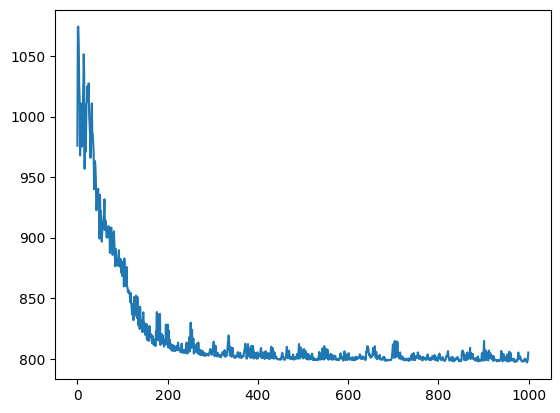

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 4.8815e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -6.1939e-05,  9.2592e-01],
         [ 5.3526e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.2069e-04, -1.6414e-04],
         [ 5.5078e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -3.7889e-03,  1.0154e-03],
         ...,
         [ 6.4764e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -5.5289e-02, -1.2442e-26],
         [ 6.5223e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           6.5757e-03,  1.5028e-27],
         [ 9.5158e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -3.1711e-04, -7.2498e-29]],

        [[ 9.9033e-02,  0.0000e+00,  3.2499e-03,  ..., -6.7304e-06,
           5.3513e-05,  8.7201e-15],
         [ 4.9271e-02,  0.0000e+00, -1.8639e-02,  ...,  3.7744e-05,
          -3.0010e-04, -4.8902e-14],
         [ 5.6076e-02,  0.0000e+00,  9.2136e-01,  ..., -3.1421e-04,
           2.4994e-03,  4.0709e-13],
         ...,
         [ 5.4316e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



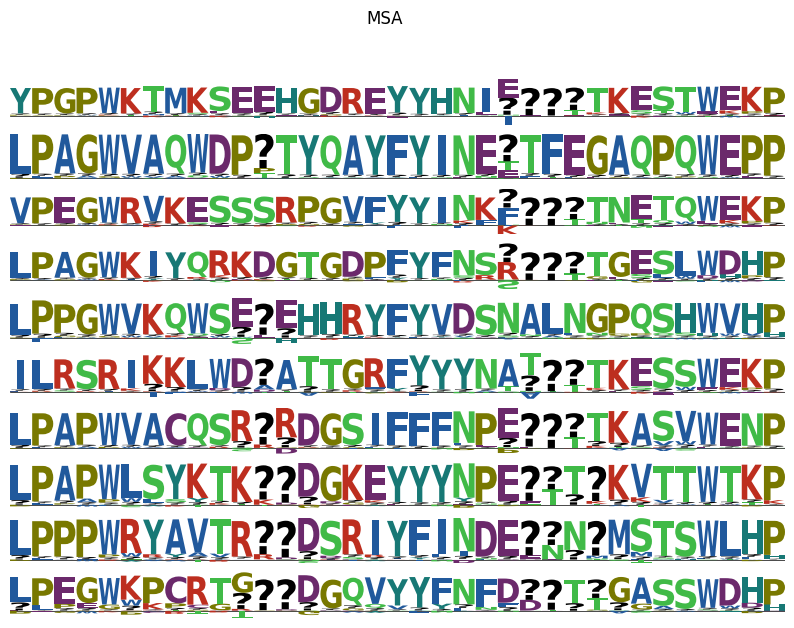

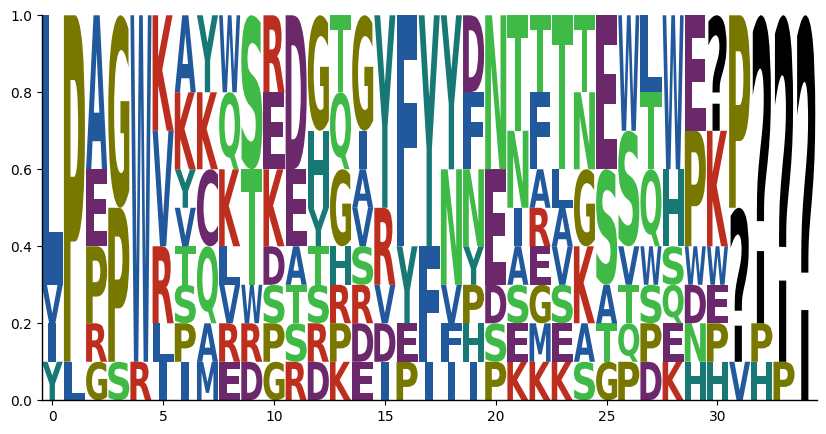

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



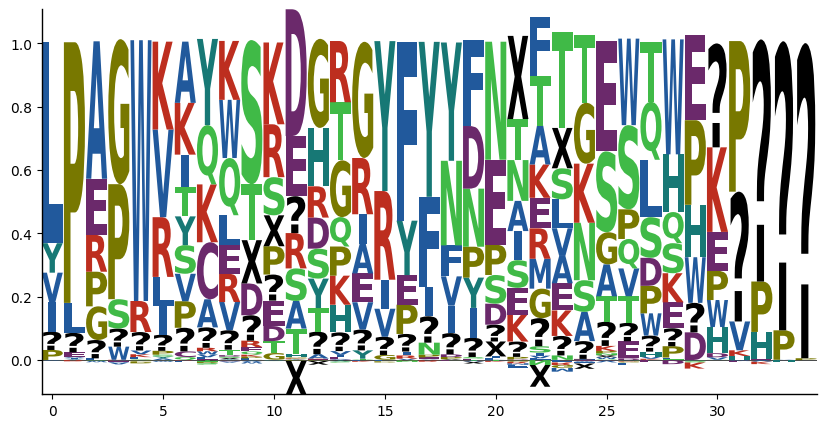

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



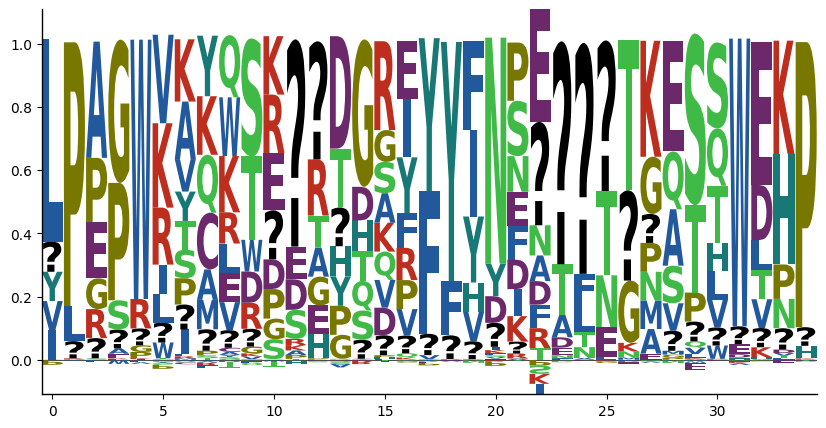

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



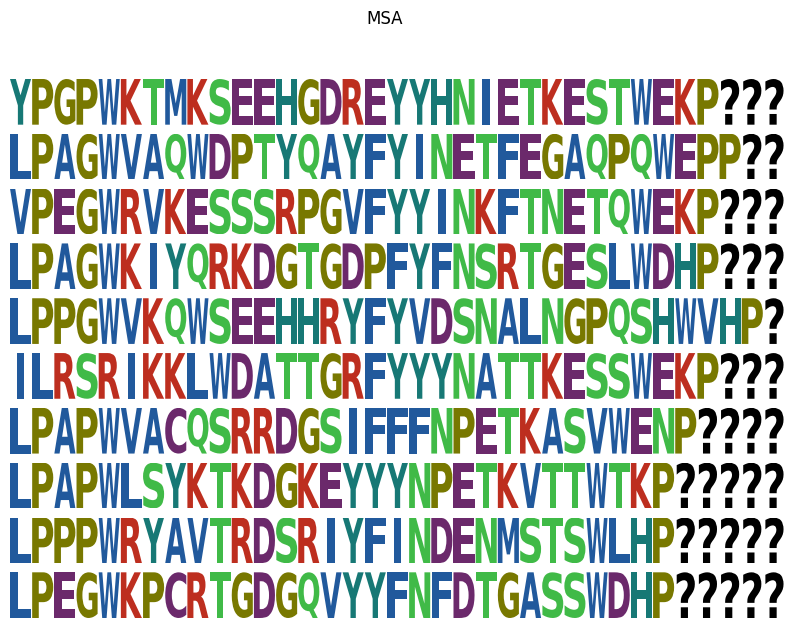

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):


    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq)
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq.to('cpu'), dataset_msa.prot_space.detach().cpu())



RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()